<center><p float="center">
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center> Real-Time Retail Feedback Intelligence
 </center></h1>


### **Business Context**
The client, which is an online retail company, is facing an increase in customer activity during festive seasons and holiday sales. During this time, the company experiences a surge in customer reviews and feedback. They highlight the importance of minimizing the delay in reading and responding to customer feedback, as it can impact their reputation and customer loyalty.

In the document shared with us, the client has provided, along with the business context and objective of the project, a dataset with a sample of customer reviews and feedback. The dataset is stored in a CSV file and contains information such as the review text and the rating given by the customer so we can develop the system that can process thousands of reviews in real-time and provide insights to the company.

### **Objective**
The objective, as expressed in the shared document, is to build a system based on Generative AI prompt engineering to fulfill the client's goals:

* Analyze and categorize sentiment of the reviews.
* Identify the product or service that the review is referring to.
* Summarize different insights by product type and priority.
* Generate automatic and personalized responses to the customers, taking sentiment into account.
* Generate short, actionable reports for the retail teams.

### **Dataset Used for the Notebook**
The dataset consists of a CSV file with the following columns:

* Clothing.ID: The ID of the clothing item being reviewed.
* Age: The age of the customer who wrote the review.
* Title: The title of the review.
* Review.Text: The text of the review.
* Rating: The rating given by the customer to the product, where 1 is the lowest rank and 5 is the highest.
* Recommended.IND: A binary variable indicating whether the customer recommended the product or not.
* Positive.Feedback.Count: The number of positive feedbacks received by the customer review.
* Division.Name: The name of the division where the product is located.
* Department.Name: The name of the department where the product is located.

### **Installing and Importing Necessary Libraries**
First, let's set up the environment by installing the required Python libraries.

In [2]:
# Install the required libraries for the project
!pip install -q numpy pandas matplotlib seaborn wordcloud openai pydantic tqdm plotly

In [3]:
# Import the required libraries for the EDA
import warnings
warnings.filterwarnings("ignore")

# Data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Logging library
from tqdm import tqdm

### **Data Loading**
### Loading and Understanding the Data


In [4]:
from pathlib import Path

# Loading the dataset
print("Loading the dataset...")

filepath = Path("Dataset - Real-Time Retail Feedback Intelligence.csv")
if not filepath.exists():
    raise FileNotFoundError(f"The file {filepath} does not exist.")

# Using sep=None and engine='python' to automatically detect the separator
# and handle potential formatting issues that cause ParserError
df = pd.read_csv(filepath, sep=None, engine='python')
print("Dataset loaded successfully.")

Loading the dataset...
Dataset loaded successfully.


### **Data Overview**

In [5]:
# Displaying the first few rows of the dataset
df.head()

,Unnamed: 0,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
0,1,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,2,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,3,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,4,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,5,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
# Getting summary of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing.ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review.Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended.IND          23486 non-null  int64 
 7   Positive.Feedback.Count  23486 non-null  int64 
 8   Division.Name            23472 non-null  object
 9   Department.Name          23472 non-null  object
 10  Class.Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In the dataset there are 23486 rows and 11 columns.

* The first column is the id of the column, and will be dropped.
* Clothing.ID, Age, Rating and Positive.Feedback.Count are **numeric columns**.
* Title, Review.Text, Division.Name, Department.Name and Class.Name are **object columns**.
* Title, Review.Text, Division.Name, Department.Name and Class.Name have **missing values**.

### **Sanity checks**

In [7]:
# We will drop the Unnamed column
try:
    df = df.drop(columns=['Unnamed: 0'])
except KeyError as err:
    print("The column 'Unnamed: 0' does was already dropped from the DataFrame.")

# We can use change the Clothing.ID to a categorical variable
df['Clothing.ID'] = df['Clothing.ID'].astype(str)

# We will do the same for the Recommended.IND column
df['Recommended.IND'] = df['Recommended.IND'].astype(str)

* The Clothing.ID column, although is numeric, will be considered as a categorical variable for the analysis given that it is a unique identifier for each clothing item and does not make sense to analyze it as a numeric variable. The same will be done for the Recommended.ID column.
* We can see that there is a lot of variability among the Title and Review.Text columns. This is ok, due to the nature of the data, which is introduced by users manually with their own words.

### **Data Cleaning and Preprocessing**

In [8]:
# For training purposes will clone de dataframe ignoring the rows where the columns 'Review.Text', 'Division.Name', 'Department.Name' and 'Class.Name' are empty
df_review = df.copy()
df_review = df_review[df_review['Review.Text'].notna() & df_review['Division.Name'].notna() & df_review['Department.Name'].notna() & df_review['Class.Name'].notna()]

# We will check the info of the dataframe after removing the rows
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22628 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing.ID              22628 non-null  object
 1   Age                      22628 non-null  int64 
 2   Title                    19662 non-null  object
 3   Review.Text              22628 non-null  object
 4   Rating                   22628 non-null  int64 
 5   Recommended.IND          22628 non-null  object
 6   Positive.Feedback.Count  22628 non-null  int64 
 7   Division.Name            22628 non-null  object
 8   Department.Name          22628 non-null  object
 9   Class.Name               22628 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.9+ MB


For training and test purposes, we will keep the rows that have all the necessary columns to analyze sentiment and correlate the feedback with the product features.

### **Exploratory Data Analysis**

#### Analyzing summary statistics of numeric columns

In [9]:
# Get a quick overview of the numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,23486.0,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,23486.0,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Positive.Feedback.Count,23486.0,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0


* The minimum age of the customers is 18 years old, while the maximum es 99. The mean is around 43 years, which is very slightly skewed to the right from the median of 41 years.
* Ratings go from 1 to 5 stars, with a mean of 5. The data is skewed to the left.
* The Possitive.Feedback.Count column has a mean of 2.5 and a standard deviation of 5.7, while the mean is 1. The minimum and maximum values are 0 and 122 respectively. The data is skewed to the right.

#### Analyzing summary statistics on categorical columns

In [10]:
# Get values in each categorical column
categorical_columns = ['Clothing.ID', 'Title', 'Review.Text', 'Division.Name', 'Department.Name', 'Class.Name']
for column in categorical_columns:
    print("=" * 50)
    print("\tAnalyzing column:", column)
    print("=" * 50)
    print("\tUnique values:", df[column].nunique())
    print("\tTop 20 values:", df[column].value_counts().head(20))
    print("\tMissing values:", df[column].isnull().sum())
    print("\tData types:", df[column].dtypes)
    print(2 * "\n")

	Analyzing column: Clothing.ID
	Unique values: 1206
	Top 20 values: Clothing.ID
1078    1024
862      806
1094     756
1081     582
872      545
829      527
1110     480
868      430
895      404
936      358
867      351
850      338
1095     327
863      306
1077     297
1059     294
1086     291
1080     289
860      288
1083     249
Name: count, dtype: int64
	Missing values: 0
	Data types: object



	Analyzing column: Title
	Unique values: 13993
	Top 20 values: Title
Love it!            136
Beautiful            95
Love                 88
Love!                84
Beautiful!           72
Beautiful dress      60
Love it              59
Gorgeous             53
Love this dress!     53
Cute top             52
Disappointed         51
Perfect              49
Great dress          49
Super cute           44
Adorable             43
Great top            42
Not for me           37
Runs small           36
Great top!           35
Great dress!         35
Name: count, dtype: int64
	Missing values: 

From the categorical data, we can see that there is a lot of variability among the Title and Review.Text, which requires a more exhaustive analysis. This will be done in the next sections.

We will focus now on the Clothing.ID, Division.Name, Department.Name and Class.Name columns:
* Clothing.ID: There are 1206 types of articles of clothing in the dataset.
* Division.Name: There 3 different divisions, which are General, General Petite and Initmates (Surely a typo of Intimates).
* Department.Name: The reviews are associated to 6 different departments, that are Tops, Dresses, Bottoms, Intimate, Jackets and Trend.
* Class.Name: There are 20 different classes of articles of clothing. These are:
    * Dresses
    * Knits
    * Blouses
    * Sweaters
    * Pants
    * Jeans
    * Fine gauge
    * Skirts
    * Jackets
    * Lounge
    * Swim
    * Outerwear
    * Shorts
    * Sleep
    * Legwear
    * Intimates
    * Layering
    * Trend
    * Casual bottoms
    * Chemises

#### Distribution of ratings

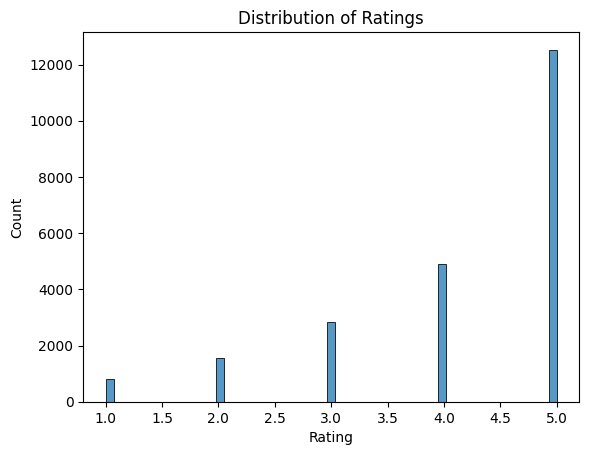

In [11]:
# Plot distribution of ratings
sns.histplot(df_review['Rating'])
plt.title('Distribution of Ratings')
plt.show()

From the reviews distribution, the standard deviation is around 1 which reflects a distribution that is biased to positive reviews, being 5 the most common rating.

#### Distribution of Ratings among Departments

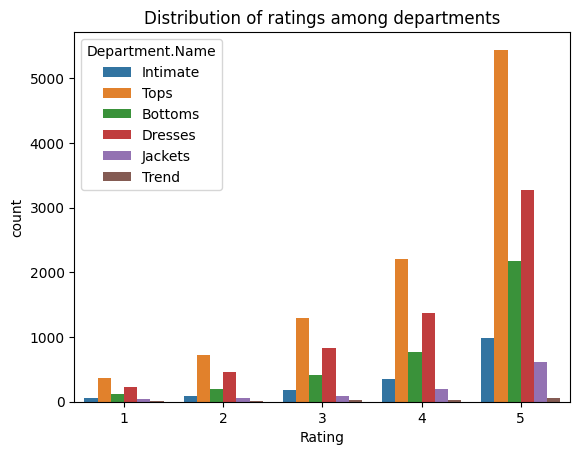

In [12]:
# Checking the distribution of ratings among departments
sns.countplot(data=df_review, x='Rating', hue='Department.Name', )
plt.title('Distribution of ratings among departments')
plt.show()

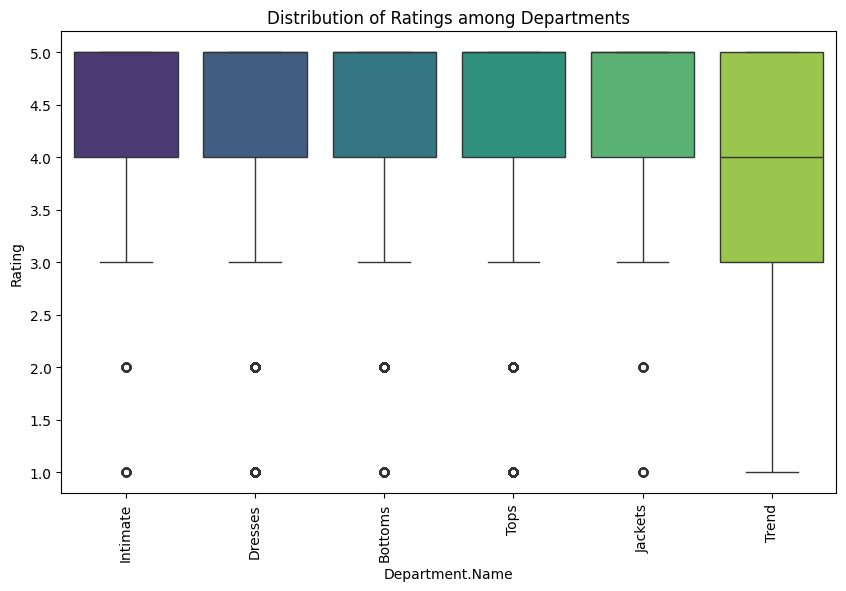

In [13]:
# Usamos boxplot para ver medianas, cuartiles y outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_review, x='Department.Name', y='Rating', palette='viridis')

plt.title('Distribution of Ratings among Departments')
plt.xticks(rotation=90)
plt.show()

The distribution of ratings among departments follows a pattern, where seems to be equally distributed for all the departments, except for the deparment of 'Trend', which has the lowest rating. This could be due to the fact that the amount of activity for this department is too high for the team to handle during these spikes of transactions.

The most rated department is 'Tops', which has the most amount of reviews, although it follows a pattern with the rest of departments along ratings from 1 to 5.

#### Distribution of Common Words in relation with Ratings

Now, we will do a basic analysis on the distribution of words used in the review texts in relation with the rating given by the customers.

In [14]:
# We import the libraries to represent the word distribution in review texts
import re
from wordcloud import WordCloud, STOPWORDS

# We create a set of stopwords to remove common words that do not add value to the word cloud
stopwords = set(STOPWORDS)

In [15]:
# Define a function so we can analyze the word distribution for different ranges of reviews
def plot_word_cloud(text_series, stopwords, title):
    # First we create a text with all the words inside the series
    reviews_text = " ".join(text_series.dropna().astype(str).tolist())

    # Then we remove any special characters and convert the text to lowercase
    reviews_text = re.sub(r"[^a-zA-Z\s]", "", reviews_text)
    reviews_text = reviews_text.lower()

    # Filter out the words that exist inside the stopwords set
    reviews_text = " ".join(word for word in reviews_text.split() if word not in stopwords)

    # Now that the text is cleaned, we can create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(reviews_text)

    # We can then display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

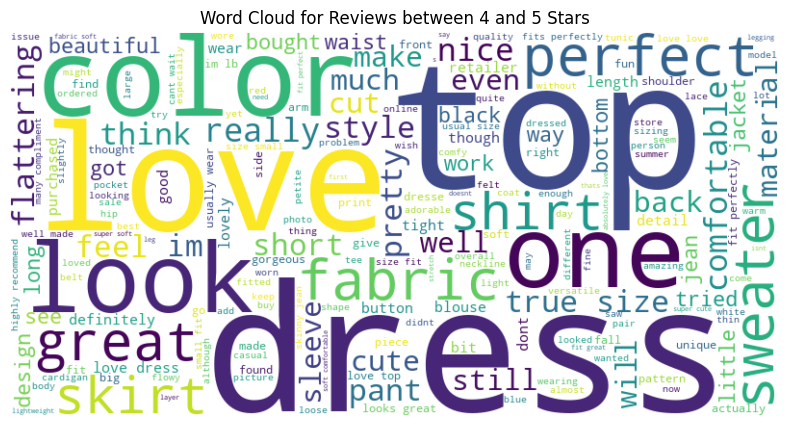

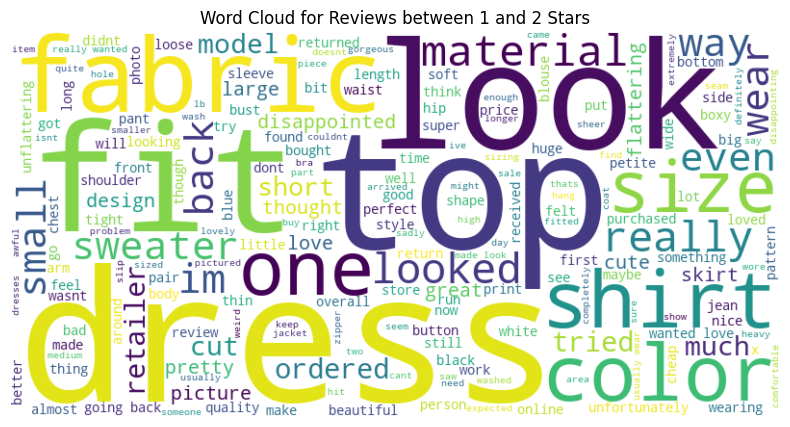

In [16]:
# Analyze word cloud for reviews between 4 and 5 stars
df_review_4_5 = df_review[df_review['Rating'] >= 4]['Review.Text']
plot_word_cloud(df_review_4_5, stopwords, title='Word Cloud for Reviews between 4 and 5 Stars')

# Analyze word cloud for reviews between 1 and 2 stars
df_review_1_2 = df_review[df_review['Rating'] <= 2]['Review.Text']
plot_word_cloud(df_review_1_2, stopwords, title='Word Cloud for Reviews between 1 and 2 Stars')

Se ven muchas referencias a palabras que hacen referencia a prendas. Voy a intentar filtrar por adjetivos y volverlo a intentar. Para ello, utilizaremos la librería 'spacy'

In [17]:
# Install spacy and download the English language model
!pip install spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------- ----------------- 7.3/12.8 MB 41.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 40.1 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [18]:
# Importing the new library spacy
import spacy

# Loading the model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Increasing the max length of the text
nlp.max_length = 6000000

In [19]:
# Define an improved function for ploting a wordcloud only using adjectives
def plot_word_cloud_adjectives(text_series, stopwords, title):
    # Join all the text in the series and remove special characters
    full_text = " ".join(text_series.dropna().astype(str).tolist())
    full_text = re.sub(r"[^a-zA-Z\s]", "", full_text).lower()

    # Process the text with spaCy
    doc = nlp(full_text)

    # Clean the words
    clean_words = [
        token.lemma_ for token in doc 
        if token.pos_ == "ADJ" and token.lemma_ not in stopwords
    ]
    
    final_text = " ".join(clean_words)

    # If there are no adjectives, return
    if not final_text:
        print(f"No se encontraron adjetivos para el título: {title}")
        return

    # Generate the wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(final_text)

    # Plot the wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

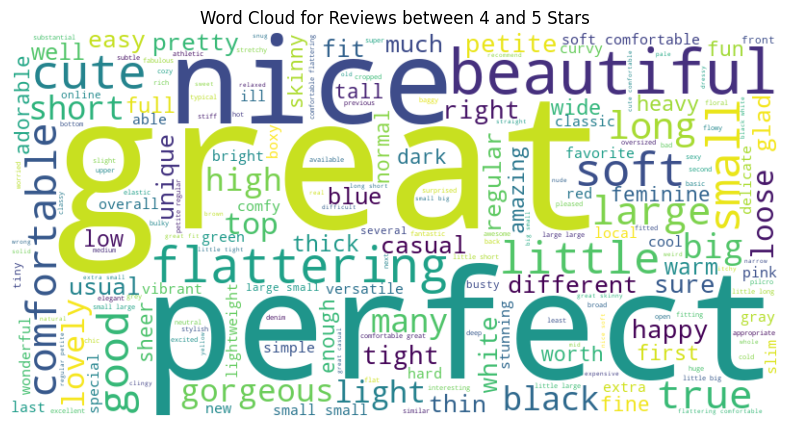

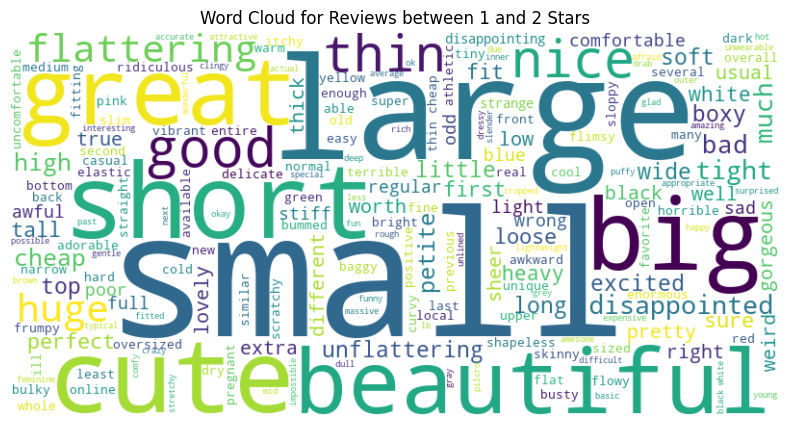

In [20]:
# Analyze word cloud for reviews between 4 and 5 stars
df_review_4_5 = df_review[df_review['Rating'] >= 4]['Review.Text']
plot_word_cloud_adjectives(df_review_4_5, stopwords, title='Word Cloud for Reviews between 4 and 5 Stars')

# Analyze word cloud for reviews between 1 and 2 stars
df_review_1_2 = df_review[df_review['Rating'] <= 2]['Review.Text']
plot_word_cloud_adjectives(df_review_1_2, stopwords, title='Word Cloud for Reviews between 1 and 2 Stars')

For analyzing the most common words in reviews between 4 and 5 and between 1 and 2, we used two approaches: filter words for each range of ratings and filter adjectives for each range of ratings.

Looking at both approaches for generating word clouds, we can see:

* For ratings between 4 and 5: 
    * For the first approach, 'Love' is a word that comes to the eyes. There are also references to clothe types, such as 'dress', 'tops', which do not give insight about the sentiment of the review, but can be helpful for determining the type of product - also we see references about 'color', 'material' and 'fabric'
    * For the second approach we can see 'great', 'beautiful', 'perfect', 'soft', 'comfortable', 'flattering'.

* For ratings between 1 and 2:
    * For the first approach we also see 'dress', 'tops' and other clothing types, and is harder to identify any relation with the sentiment of the review.
    * For the second approach, there are references to the sizes of cloth, like 'small', 'large', 'short', 'big', but also references to words that relate to good sentiments like good, beautiful. There are some evident words that relates to bad reviews like disappointed and scratchy that are mildly visible.


From this preliminar analysis, we can see that there is some ambiguity in most common words if we want to releate them to sentiment. But it can be useful to determine the clothing type and hints on characteristics that are important for the customer.

## **Building the Generative AI Pipeline**

We will now build a system to analyze the reviews. This involves setting up the AI client, designing prompts, generating structured data, and evaluating the results.

For this part, we will be defining different functions that will be used in the next sections during the pipeline definitions.

#### **Setup AI Client and Data Sample**
    

For the Generative AI Pipeline, we will initialize a LLM Client using the OpenAI API. 

In [21]:
# Import the necesary libraries to initialize the OpenAI client
import os
import json
from openai import OpenAI

Initialize the LLM Client using a JSON file for storing the API key.

In [24]:
# Load the API key from the JSON file
print("Loading API key from JSON file...")
with open('api_key.json', 'r') as f:
    api_key_file_info = json.load(f)

gl_openai_api_key = api_key_file_info['openai_api_key']
gl_openai_base_url = api_key_file_info['openai_base_url']
gl_openai_model = api_key_file_info['openai_model']

# Initialize the OpenAI client
print("Initializing OpenAI client...")
client = OpenAI(api_key=gl_openai_api_key, base_url=gl_openai_base_url)

print("API key loaded successfully. ")


Loading API key from JSON file...
Initializing OpenAI client...
API key loaded successfully. 


In [25]:
# List the top 5 models
print("List of available models:")
models = client.models.list()
model_ids = [model.id for model in list(models)[:]]

for name in model_ids:
    print(f"- {name}")

List of available models:
- gpt-4-0613
- gpt-4
- gpt-3.5-turbo
- gpt-5.2-codex
- gpt-4o-mini-tts-2025-12-15
- gpt-realtime-mini-2025-12-15
- gpt-audio-mini-2025-12-15
- chatgpt-image-latest
- davinci-002
- babbage-002
- gpt-3.5-turbo-instruct
- gpt-3.5-turbo-instruct-0914
- dall-e-3
- dall-e-2
- gpt-4-1106-preview
- gpt-3.5-turbo-1106
- tts-1-hd
- tts-1-1106
- tts-1-hd-1106
- text-embedding-3-small
- text-embedding-3-large
- gpt-4-0125-preview
- gpt-4-turbo-preview
- gpt-3.5-turbo-0125
- gpt-4-turbo
- gpt-4-turbo-2024-04-09
- gpt-4o
- gpt-4o-2024-05-13
- gpt-4o-mini-2024-07-18
- gpt-4o-mini
- gpt-4o-2024-08-06
- chatgpt-4o-latest
- gpt-4o-audio-preview
- gpt-4o-realtime-preview
- omni-moderation-latest
- omni-moderation-2024-09-26
- gpt-4o-realtime-preview-2024-12-17
- gpt-4o-audio-preview-2024-12-17
- gpt-4o-mini-realtime-preview-2024-12-17
- gpt-4o-mini-audio-preview-2024-12-17
- o1-2024-12-17
- o1
- gpt-4o-mini-realtime-preview
- gpt-4o-mini-audio-preview
- computer-use-preview
- o3

From all the models available, we will select gpt-4o-mini.

**Helper functions**

Before going further, we will define some useful functions and structures to test our prompts. The objective is to create at least one function for each of the following tasks:

1. Generate the responses for single rows
2. Evaluate the responses for single rows
3. Generate and evaluate the responses for multiple rows (full flow)

As for best practices, these funtions will try to be sufficiently restrictive in the output format, using pydantic, but also generic so we can use them for the different prompting techniques we will try.

In [86]:
# This library is used to parse the response from OpenAI
from pydantic import BaseModel
from typing import Literal, Optional


# We will use pydantic to define the response format and save us the step of parsing the response
class ReviewAnalysis(BaseModel):
    category: Literal["fit", "quality", "design", "price", "delivery", "other"]
    product_or_service: Literal["product", "service"]
    urgency_level: Literal["high", "medium", "low"]
    sentiment: Literal["positive", "negative", "neutral"]
    summary: str
    personalized_message: str
    retail_insight: str


# Define a function to process the review. This function will be used for all prompting techniques
def process_review(openai_client: OpenAI, system_prompt: str, review_text: str, model: str = "gpt-4o-mini", examples: Optional[list] = None, response_format: Optional[BaseModel] = ReviewAnalysis, **kwargs) -> BaseModel:
    """
    Process a review using OpenAI's GPT-4o-mini model. 

    Args:
        openai_client (OpenAI): The OpenAI client.
        system_prompt (str): The system prompt to use for the review.
        review_text (str): The review text to process.
        model (str, optional): The model to use for the review. Defaults to "gpt-4o-mini".
    
    Returns:
        dict: The response from the OpenAI model.
    """

    try:
        messages = [ {"role": "system", "content": system_prompt} ]

        # Preparation for few-shot prompting
        if examples:
            for example in examples:
                messages.append({"role": "user", "content": example["review_text"]})
                messages.append({"role": "assistant", "content": example["analysis"]})

        # Add the review text to the messages
        messages.append({"role": "user", "content": review_text})

        # Parse the response using pydantic
        response = openai_client.beta.chat.completions.parse(
            model=model,
            messages=messages,
            response_format=response_format,
            **kwargs
        )
        return response.choices[0].message.parsed
    except Exception as e:
        print(f"Error processing review: {e}")
        return None    


Now we will test the function and structured response with a smoke test prompt.

In [29]:
smoke_test_prompt = "You are a retail expert from customer service"
smoke_test_review = "This shirt is so comfy and soft!"

# After defining the process_review function, we will test it with a simple example
smoke_test = process_review(
    openai_client=client, 
    system_prompt=smoke_test_prompt, 
    review_text=smoke_test_review
)

print(smoke_test)

category='quality' product_or_service='product' urgency_level='low' sentiment='positive' summary='The shirt is praised for its comfort and softness.' personalized_message="Thank you for your positive feedback! We're glad to hear you find the shirt comfy and soft. Enjoy your purchase!" retail_insight='Highlighting the quality and comfort of products in marketing can attract more customers and encourage repeat purchases.'


Now we are going to define a function to evaluate the model responses. For this, we will use an LLM-as-a-Judge (LLM-Judge) to measure different aspects of the responses.

The evaluation parameters for the response will be as follows:

* LLM-Judge: We will use the LLM-Judge to measure the quality of the responses. The LLM-Judge will be used to evaluate the responses based on the following criteria:

    * Factuality: The response should be verifiable. (0.40 points)
    * Relevance: The response should actually answer the question. (0.30 points)
    * Clarity: The response should be clear and easy to understand. (0.15 points)
    * Efficiency: The response should be concise and provide the necessary information without being too long. (0.15 points)

    

In [30]:
from pydantic import Field, validator

class JudgeEvaluation(BaseModel):
    relevance: float = Field(description="Does the response address the original review? 10 = Perfect, 0 = No relevance", ge=0, le=10)
    factuality: float = Field(description="Is the response verifiable against the original review and context? 10 = Perfect, 0 = No factuality", ge=0, le=10)
    clarity: float = Field(description="Is the response clear and easy to understand? 10 = Perfect, 0 = No clarity", ge=0, le=10)
    structure: float = Field(description="Is the response well-structured? 10 = Perfect, 0 = No structure", ge=0, le=10)
    hallucination_detected: bool = Field(description="Is the model making up information that is not in the original review or context?")
    justification: str = Field(description="Brief justification for the evaluation score. Maximum 2 sentences. Focus on the reason for penalties")

    @validator("relevance", "factuality", "clarity", "structure")
    def check_score_range(cls, v):
        if v < 0 or v > 10:
            raise ValueError("Score must be between 0 and 10")

        # We will convert the score to a float between 0 and 1
        return v / 10


def get_judge_evaluation(openai_client: OpenAI, original_review: str, response: BaseModel, model: str = "gpt-4o-mini") -> JudgeEvaluation:
    """
    Evaluate the quality of the response generated by the model.

    Args:
        openai_client: OpenAI client instance.
        original_review: Original review text.
        response: BaseModel object containing the response.
        model: Model to use for evaluation.

    Returns:
        JudgeEvaluation: Evaluation object containing the score and justification.
    """
    # Transform the response to a dictionary so the model can read it
    response_dict = response.model_dump()

    # Generate the response
    response = openai_client.beta.chat.completions.parse(
        model=model,
        messages=[
            {"role": "system", 
            "content": (
                "You are a rigorous AI Quality Auditor. Your goal is to evaluate an analysis of a response based on an original review."
                )
            },
            {"role": "user", "content": f"Original review: {original_review}\nReview Analysis: {response_dict}"}
        ],
        response_format=JudgeEvaluation,
        temperature=0,
    )

    # Return the score
    return response.choices[0].message.parsed


def calculate_total_score(judge_evaluation: JudgeEvaluation, response: BaseModel) -> float:
    """
    Evaluate the quality of the response generated by the model.

    Args:
        judge_evaluation: JudgeEvaluation object containing the score and justification.
        response: BaseModel object containing the response.

    Returns:
        float: Total score of the response.
    """

    # Calculate the efficiency of the response, penalizing if the message is too long
    efficiency = 1.0 if len(response.personalized_message) < 100 and len(response.retail_insight) < 100 else 0.4

    # Defining weights for the criteria
    weights = {
        "factuality": 0.4,
        "relevance": 0.3,
        "clarity": 0.15,
        "efficiency": 0.15
    }

    # Calculate the total score
    total_score = (
        weights["factuality"] * judge_evaluation.factuality +
        weights["relevance"] * judge_evaluation.relevance +
        weights["clarity"] * judge_evaluation.clarity +
        weights["efficiency"] * efficiency
    )

    return round(total_score, 4)

Once the judge evaluation is defined, we can test it again the smoke test prompt we defined before:

In [32]:
# Evaluating smoke test result
smoke_test_evaluation = get_judge_evaluation(client, smoke_test_review, smoke_test)

In [33]:
print("Judge evaluation: ")
print(smoke_test_evaluation)

Judge evaluation: 
relevance=1.0 factuality=1.0 clarity=1.0 structure=1.0 hallucination_detected=False justification="The analysis accurately reflects the original review's sentiment and key points about comfort and softness. It is well-structured, clear, and provides relevant insights without introducing any unverifiable information."


In [35]:
# Calculate smoke test score
smoke_test_score = calculate_total_score(smoke_test_evaluation, smoke_test)
print("Smoke test score: ", smoke_test_score)

Smoke test score:  0.91


From the test we could verify that the model is able to generate a response and the judge evaluation is able to evaluate the response with a score that is according to the rules we set. 

**Sample Preparation**

Now that we have defined the basic functions for the model testing, we will prepare a function that randomly selects N reviews, making sure we have a mix of positive and negative reviews and covering different product categories.

In [36]:
def get_balanced_sample(df, n=15, balance_threshold=4):
    """
    Samples reviews from the dataframe until a balanced distribution of ratings is found
    based on the harmonic mean of positive, negative, and neutral counts.
    """
    random_state = 1
    while True:
        df_sample = df.sample(n=n, random_state=random_state)

        # Count frequencies of each rating category
        positive_rating = len(df_sample[df_sample['Rating'] > 3])
        negative_rating = len(df_sample[df_sample['Rating'] < 3])
        neutral_rating = len(df_sample[df_sample['Rating'] == 3])

        # Check for any zero counts to avoid division by zero in harmonic mean
        if positive_rating == 0 or negative_rating == 0 or neutral_rating == 0:
            counts = [0.1, 0.1, 0.1]
        else:
            counts = [positive_rating, negative_rating, neutral_rating]

        # Calculate harmonic mean
        harmonic_mean = len(counts) / sum(1 / count for count in counts)
        
        if harmonic_mean >= balance_threshold:
            return df_sample, random_state
        
        random_state += 1

In [37]:
# Execute the refactored function
df_preliminar_sample, random_state = get_balanced_sample(df_review)

# Print results
print("Random state:", random_state)
print(df_preliminar_sample['Rating'].value_counts())
df_preliminar_sample.head()

Random state: 56
Rating
5    5
2    4
3    3
4    2
1    1
Name: count, dtype: int64


,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
11998,602,36,Not what i expected,This romper was not what i expected when i ori...,3,0,0,General,Bottoms,Shorts
20437,1081,53,Not what i had hoped for,On a positive note the dress was very well mad...,2,0,1,General,Dresses,Dresses
6827,384,30,Very nice,"I'm not sure what cup size i am, 36b or 36c, b...",5,1,0,Initmates,Intimate,Intimates
19945,514,46,"Cute design, impossible fit",I tried this on in my regular size and was abl...,2,0,9,Initmates,Intimate,Swim
3446,841,35,Not as expected,"In paper crown dresses, i wear a small or size...",2,0,11,General Petite,Tops,Blouses


In [38]:
# Execute the refactored function
df_final_sample, random_state = get_balanced_sample(df_review, n=50, balance_threshold=14)

# Print results
print("Random state:", random_state)
print(df_final_sample['Rating'].value_counts())
df_final_sample.head()

Random state: 1357
Rating
5    22
3    11
2     9
1     4
4     4
Name: count, dtype: int64


,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
20038,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge
8486,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge
11067,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits
14361,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters
22463,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear


We implemented a brute force algorithm to find a mildly balanced sample of the dataset, asuming there is a correlation between the rating and the sentiment of the review, resulting in:

* Preliminar sample (df_preliminar_sample) of 15 reviews with 5 'negative' reviews (less than 3), 7 possitives (greater than 3) and 3 neutral reviews (equal to 3).
* Final sample (df_final_sample) of 50 reviews with 13 'negative' reviews (less than 3), 26 possitives (greater than 3) and 11 neutral reviews (equal to 3).

**Result formatting**

Here we define a function to test the full flow of a prompt technique test

In [145]:
def prompt_test_run(openai_client: OpenAI, system_prompt: str, reviews: pd.DataFrame, examples: Optional[list] = None, model: str = "gpt-4o-mini", response_format: Optional[BaseModel] = ReviewAnalysis, **kwargs):
    """
    Run a test of the prompt on a sample of reviews.
    
    Args:
        openai_client (OpenAI): The OpenAI client.
        system_prompt (str): The system prompt to use for the review.
        reviews (pd.DataFrame): The reviews to process.
        examples (Optional[list], optional): The examples to use for the review. Defaults to None.
        model (str, optional): The model to use for the review. Defaults to "gpt-4o-mini".
        response_format (Optional[BaseModel], optional): The response format to use for the review. Defaults to ReviewAnalysis.

    Returns:
        tuple: A tuple containing the prompt test results, prompt results evaluation, prompt test scores, and the mean of the prompt test scores.
    """
    print(f"Testing prompt: {system_prompt}")
    if examples:
        print("Using examples:")
        for example in examples:
            print(example)
    
    print(f"Running prompt test accross {len(reviews)} samples...")
    prompt_test_results = [process_review(openai_client=openai_client, system_prompt=system_prompt, review_text=review_text, model=model, examples=examples, response_format=response_format, **kwargs) for review_text in tqdm(reviews["Review.Text"], desc="Processing reviews...")]

    print("Evaluating prompt test results...")
    prompt_results_evaluation = [get_judge_evaluation(openai_client=openai_client, original_review=review_text, model=model, response=prompt_test_results[idx]) for idx, review_text in tqdm(enumerate(reviews["Review.Text"]), desc="Evaluating prompt test results...")]

    print("Calculating total score...")
    prompt_test_scores = [calculate_total_score(judge_evaluation=judge_evaluation, response=prompt_test_results[idx]) for idx, judge_evaluation in tqdm(enumerate(prompt_results_evaluation), desc="Prompt test scores")]

    return (prompt_test_results, prompt_results_evaluation, prompt_test_scores, np.mean(prompt_test_scores))

At last, we will define a function that let's transform the prompt system results (ReviewAnalysis and Score lists) into a pandas DataFrame.

In [39]:
def results_to_dataframe(analysis_results: list[ReviewAnalysis], scores: list[float], prefix: str) -> pd.DataFrame:
    """
    Converts ReviewAnalysis results and their scores into a DataFrame.
    """
    # 1. Convert Pydantic results to a list of dictionaries
    data = [item.model_dump() for item in analysis_results]
    
    # 2. Create DataFrame
    df_results = pd.DataFrame(data)
    
    # 3. Add the scores column
    df_results['score'] = scores
    
    # 4. Add prefix to column names
    return df_results.add_prefix(prefix)

**Functions for visualization**   

To keep the code clean and organized, we will define a function to print a commonly used summary of the results obtained by each prompting technique.

In [66]:
def print_results_summary(prompt_results: list, judge_results: list, scores: list, avg_score: float, test_name: str):
    """
    Print a summary of the results from the prompt and judge.
    
    Args:
        prompt_results (list): The results from the prompt.
        judge_results (list): The results from the judge.
        scores (list): The scores from the judge.
        avg_score (float): The average score from the judge.
        test_name (str): The name of the test.
    """
    print(f"{test_name} results: ")
    for idx, result in enumerate(prompt_results):
        print(f"Review {idx + 1}: {result}")

    print("\n")
    print(f"{test_name} judge results: ")
    for idx, result in enumerate(judge_results):
        print(f"Review {idx + 1}: {result}")

    print("\n")
    print(f"{test_name} scores: ")
    for idx, score in enumerate(scores):
        print(f"Review {idx + 1}: {score}")

    print("\n")
    print(f"{test_name} average score: ", avg_score)

#### **Prompt Engineering and Evaluation**

We will test three different prompting techniques. For each, we will create a basic version (V1) and an enhanced version (V2).

The steps for designing each prompt system:

1. For each version, we will create an initial prompt that iteratively refines the model responses.

2. These responses will be evaluated by the judge function defined in the previous sections..   

3. For the each version, we will test against 15 balanced random selected reviews. Then we will evaluate a larger set of reviews (50).
    
4. The results for each version is going to be summarized into an average score.

#### **Technique 1: Zero-Shot Prompting**
    

**First version of Zero-shot system**

During this phase we are going to test basic prompts using zero-shot techniques, so we can validate the quality of the responses and select the first version of the system. For this phase we will be using the preliminar dataset which only have 15 reviews.

In [ ]:
# We will start with the simplest prompt. The same that we used for the smoke test before
v1_zero_shot_prompt = "You are a retail expert from customer service"

# Runing prompt test flow
v1_zero_shot_results, v1_zero_shot_llm_judge_results, v1_zero_shot_scores, v1_zero_shot_avg_score = prompt_test_run(openai_client=client, system_prompt=v1_zero_shot_prompt, reviews=df_preliminar_sample.head(3))

Testing prompt: {system_prompt}
Running prompt test accross 3 samples...










Processing reviews...: 100%|██████████| 3/3 [00:12<00:00,  4.27s/it]


Evaluating prompt test results...










Evaluating prompt test results...: 3it [00:05,  2.00s/it]


Calculating total score...




Prompt test scores: 3it [00:00, 3003.08it/s]


In [67]:
# Print the results summary for the preliminar test set for the v1 zero-shot technique
print_results_summary(v1_zero_shot_results, v1_zero_shot_llm_judge_results, v1_zero_shot_scores, v1_zero_shot_avg_score, "Zero-shot V1 preliminar")

Zero-shot V1 preliminar results: 
Review 1: category='quality' product_or_service='product' urgency_level='medium' sentiment='negative' summary='The romper was casual looking and a button fell off upon receiving it, leading to a return despite a good fit.' personalized_message="We're sorry to hear that the romper didn’t meet your expectations! We appreciate your feedback and will work to improve our quality control." retail_insight='Quality issues, such as buttons falling off, can lead to increased return rates. Ensuring proper quality checks before shipping can enhance customer satisfaction.'
Review 2: category='design' product_or_service='product' urgency_level='medium' sentiment='negative' summary='The dress was well made with great quality but was unflattering and sack-like in design, which led to a return.' personalized_message="We're sorry to hear that the dress didn't meet your expectations. Your feedback on the design helps us improve our offerings." retail_insight='While the q

After tuning the system and fixing the errors during this preliminar analysis, we can move on to apply the system to a larger scale and determine it's score.

In [144]:
# Executing the prompt test run for v1_zero_shot_prompt using the final sample (50 reviews)
v1_zero_shot_final_results, v1_zero_shot_llm_judge_final_results, v1_zero_shot_final_scores, v1_zero_shot_avg_final_score = prompt_test_run(openai_client=client, system_prompt=v1_zero_shot_prompt, reviews=df_final_sample)

Testing prompt: {system_prompt}
Running prompt test accross 50 samples...


Processing reviews...: 100%|██████████| 50/50 [03:13<00:00,  3.88s/it]


Evaluating prompt test results...


Evaluating prompt test results...: 50it [01:52,  2.25s/it]


Calculating total score...


Prompt test scores: 50it [00:00, 50063.31it/s]


In [146]:
# V1 Zero-shot prompting results summary
print_results_summary(v1_zero_shot_final_results, v1_zero_shot_llm_judge_final_results, v1_zero_shot_final_scores, v1_zero_shot_avg_final_score, "V1 Zero-shot final")


V1 Zero-shot final results: 
Review 1: category='quality' product_or_service='product' urgency_level='low' sentiment='positive' summary='Customer is very satisfied with the softness and comfort of the sweater, mentioning its flattering design and wrinkle-free back. They have purchased it in multiple colors and highly recommend it.' personalized_message="Thank you for sharing your positive experience! We're thrilled to hear that you love the sweater in both navy and grey. Your recommendation means a lot to us!" retail_insight='Highlighting the softness and comfort in product descriptions can attract more customers, especially for clothing.'
Review 2: category='fit' product_or_service='product' urgency_level='medium' sentiment='negative' summary='The top was described as frumpy and boxy, lacking a flattering fit, even for a larger size, leaving a negative impression on the buyer.' personalized_message="We appreciate your feedback and understand how important a good fit is. We're here to 

**Second version of Zero-Shot system**

Now that we have a working Zero-Shot system, we can start to build an enhanced version of it. For this, we will:

1. Add some guardrails to the system to make it more factual and robust.
2. Add some context about the company and tone of the response.
3. Give special attention to the accuracy of the system.

Here we start with a preliminar testing, using the same 15 reviews that we used for the first version of the zero-shot prompt system.

In [ ]:
# Define the v2 zero_shot prompt that uses company context, tone and encourage factuality in the response
v2_zero_shot_prompt = """
You are an expert analyst for the retail company 'ChicStyle' which has a growing fashion retail platform.

Your tone must be luxurious, sophisticated and relatable to the customer.

Your response must be:

1. Factually correct and based on the company context and the review text.
2. Both personalized message and retail insight must be concise and to the point.
3. The responses must be relevant to the review text.
4. Your response should be clear and easy to understand.

"""

# Execute analysis for the 15 preliminar reviews
v2_zero_shot_results, v2_zero_shot_llm_judge_results, v2_zero_shot_scores, v2_zero_shot_avg_score = prompt_test_run(openai_client=client, system_prompt=v2_zero_shot_prompt, reviews=df_preliminar_sample.head(3))

Testing prompt: {system_prompt}
Running prompt test accross 3 samples...


Processing reviews...: 100%|██████████| 3/3 [00:10<00:00,  3.44s/it]


Evaluating prompt test results...


Evaluating prompt test results...: 3it [00:07,  2.38s/it]


Calculating total score...


Prompt test scores: 3it [00:00, ?it/s]


In [95]:
# V2 Zero-shot prompting results summary
print_results_summary(v2_zero_shot_results, v2_zero_shot_llm_judge_results, v2_zero_shot_scores, v2_zero_shot_avg_score, "V2 Zero-shot preliminar")

V2 Zero-shot preliminar results: 
Review 1: category='quality' product_or_service='product' urgency_level='medium' sentiment='negative' summary='The romper did not meet expectations due to its casual appearance and a button that fell off upon unpacking.' personalized_message="Thank you for sharing your experience with us. We're sorry to hear that the romper didn't align with your expectations and that you encountered a quality issue." retail_insight='Quality assurance is paramount for ChicStyle, and we appreciate your feedback as it helps us enhance our offerings. We strive to ensure our products meet the luxurious standards our customers deserve.'
Review 2: category='design' product_or_service='product' urgency_level='medium' sentiment='negative' summary='The customer appreciated the quality of the dress but found the design unflattering and shapeless, leading to a return.' personalized_message='Dear Valued Customer, thank you for sharing your thoughts on the dress. We are pleased to 

After tuning the system and fixing the errors during this preliminar analysis, we can move on to apply the system to a larger scale and determine it's score.

In [147]:
# Executing the prompt test run for v2_zero_shot_prompt using the final sample (50 reviews)
v2_zero_shot_final_results, v2_zero_shot_llm_judge_final_results, v2_zero_shot_final_scores, v2_zero_shot_avg_final_score = prompt_test_run(openai_client=client, system_prompt=v2_zero_shot_prompt, reviews=df_final_sample)

Testing prompt: 
You are an expert analyst for the retail company 'ChicStyle' which has a growing fashion retail platform.

Your tone must be luxurious, sophisticated and relatable to the customer.

Your response must be:

1. Factually correct and based on the company context and the review text.
2. Both personalized message and retail insight must be concise and to the point.
3. The responses must be relevant to the review text.
4. Your response should be clear and easy to understand.


Running prompt test accross 50 samples...


Processing reviews...: 100%|██████████| 50/50 [02:43<00:00,  3.28s/it]


Evaluating prompt test results...


Evaluating prompt test results...: 50it [01:57,  2.34s/it]


Calculating total score...


Prompt test scores: 50it [00:00, ?it/s]


In [148]:
# V2 Zero-shot prompting results summary
print_results_summary(v2_zero_shot_final_results, v2_zero_shot_llm_judge_final_results, v2_zero_shot_final_scores, v2_zero_shot_avg_final_score, "V2 Zero-shot final")


V2 Zero-shot final results: 
Review 1: category='quality' product_or_service='product' urgency_level='low' sentiment='positive' summary='Customer loves the sweater for its softness, comfort, and flattering fit, and has purchased it in multiple colors.' personalized_message="Dear valued customer, thank you for sharing your delight with our lovely sweater! We're thrilled to hear how much you appreciate its softness and flattering qualities. Your recommendation means the world to us!" retail_insight='The positive feedback highlights the quality and comfort of our products, suggesting that customers are likely to make repeat purchases when satisfied.'
Review 2: category='fit' product_or_service='product' urgency_level='medium' sentiment='negative' summary="The top was perceived as frumpy and boxy, not fitting well for the customer's shape and height." personalized_message='Thank you for sharing your thoughts on the top. We strive to provide styles that flatter every body type, and I am sor

**Save V1 and V2 Zero-Shot results into a DF**

The resutls for V1 and V2 Zero-Shot will be saved to analyze further in the final comparision.

In [149]:
# Save final results into a data frame
df_v1_zs = results_to_dataframe(v1_zero_shot_final_results, v1_zero_shot_final_scores, "V1_Zero_Shot_")
df_v2_zs = results_to_dataframe(v2_zero_shot_final_results, v2_zero_shot_final_scores, "V2_Zero_Shot_")
df_zero_shot_comparison = pd.concat([df_v1_zs, df_v2_zs], axis=1)

# Making sure to reset indices to avoid mismatch
df_zero_shot_comparison.reset_index(drop=True, inplace=True)
df_final_sample.reset_index(drop=True, inplace=True)

# Save final results into the final sample dataframe
df_final_sample = pd.concat([df_final_sample, df_zero_shot_comparison], axis=1)
df_final_sample.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V1_Zero_Shot_retail_insight,V1_Zero_Shot_score,V2_Zero_Shot_category,V2_Zero_Shot_product_or_service,V2_Zero_Shot_urgency_level,V2_Zero_Shot_sentiment,V2_Zero_Shot_summary,V2_Zero_Shot_personalized_message,V2_Zero_Shot_retail_insight,V2_Zero_Shot_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,Highlighting the softness and comfort in produ...,0.910,quality,product,low,positive,"Customer loves the sweater for its softness, c...","Dear valued customer, thank you for sharing yo...",The positive feedback highlights the quality a...,0.910
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,Consider offering clearer sizing guides or fit...,0.895,fit,product,medium,negative,"The top was perceived as frumpy and boxy, not ...",Thank you for sharing your thoughts on the top...,Fit can greatly influence customer satisfactio...,0.910
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,Highlight the versatility and comfort of the p...,0.910,design,product,low,positive,The peplum top is beautifully designed for lon...,"Dear Stylish Customer, we are thrilled to hear...",Our customers appreciate thoughtfully designed...,0.910
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,Customers often prioritize quality over design...,0.895,quality,product,medium,negative,"The cardigan has a wonderful fit and color, bu...",Thank you for sharing your experience with our...,It is crucial for us to maintain high standard...,0.910
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,Ensure accurate sizing guides and quality chec...,0.895,fit,product,medium,negative,The customer was disappointed with the coat du...,"Dear ChicStyle Customer, we sincerely apprecia...",It's crucial for our products to meet both aes...,0.895


#### **Technique 2: Few-Shot Prompting**

For this approach, we will start with a simple prompt, with 3 basic examples representing positive, negative and neutral reviews.

Then we will refine the first model adding guardrails and rules to guide the model's response against ambiguous and contradictory reviews.

**First Version of Few-Shot Prompting System**

Reusing the same functions defined before, let's start testing for the v1 few-shot prompting system

In [150]:
# We will keep the prompt simple and focused on the task
v1_few_shot_prompt = "You are a retail expert from customer service"

# Define some basic examples that represent positive, negative, and neutral feedback
v1_few_shot_examples = [
    {
        "review_text": "I love these jeans, they fit perfectly!",
        "analysis": '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'
    },
    {
        "review_text": "The blouse was missing a button.",
        "analysis": '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalized_message": "We apologize for the quality issue.", "retail_insight": "Check QC in blouses"}'
    },
    {
        "review_text": "The delivery took two weeks. The pants are fine, they fit as expected, but nothing special about the fabric.",
        "analysis": '{"category": "delivery", "urgency_level": "low", "sentiment": "neutral", "summary": "Fit is okay, but delivery was slow and fabric is average.", "personalized_message": "Thank you for your feedback. We are glad the fit worked out, and we will work on our delivery times.", "retail_insight": "Standard product performance, logistics needs review."}'
    }
]

In [108]:
# Executing the prompt test run for v1_few_shot_prompt using the preliminar sample (15 reviews)
v1_few_shot_results, v1_few_shot_llm_judge_results, v1_few_shot_scores, v1_few_shot_avg_score = prompt_test_run(openai_client=client, system_prompt=v1_few_shot_prompt, reviews=df_preliminar_sample.head(3), examples=v1_few_shot_examples)

Testing prompt: {system_prompt}
Using examples:
{'review_text': 'I love these jeans, they fit perfectly!', 'analysis': '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'}
{'review_text': 'The blouse was missing a button.', 'analysis': '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalized_message": "We apologize for the quality issue.", "retail_insight": "Check QC in blouses"}'}
{'review_text': 'The delivery took two weeks. The pants are fine, they fit as expected, but nothing special about the fabric.', 'analysis': '{"category": "delivery", "urgency_level": "low", "sentiment": "neutral", "summary": "Fit is okay, but delivery was slow and fabric is average.", "personalized_message": "Thank you for your feedback. We are glad the fit worked out, and we will work on our delivery times.", "re

Processing reviews...: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Evaluating prompt test results...


Evaluating prompt test results...: 3it [00:05,  1.85s/it]


Calculating total score...


Prompt test scores: 3it [00:00, ?it/s]


In [109]:
# V1 few-shot prompting results summary
print_results_summary(v1_few_shot_results, v1_few_shot_llm_judge_results, v1_few_shot_scores, v1_few_shot_avg_score, "V1 few-shot preliminar")


V1 few-shot preliminar results: 
Review 1: category='quality' product_or_service='product' urgency_level='high' sentiment='negative' summary='Casual appearance and quality issue with buttons, leading to return.' personalized_message="We're sorry to hear the romper didn't meet your expectations. Thank you for your feedback on the quality." retail_insight='Product appeal may vary; ensure clear product descriptions.'
Review 2: category='design' product_or_service='product' urgency_level='medium' sentiment='negative' summary='Great quality but unflattering design' personalized_message="We appreciate your feedback and are sorry to hear the design didn't work for you. We will take your comments into consideration for future styles." retail_insight='Quality is strong but design may not cater to diverse body types.'
Review 3: category='fit' product_or_service='product' urgency_level='medium' sentiment='positive' summary='Perfect fit for home wear, soft material, but caution on underwear size.'

After doing the preliminar tests, we can go ahead and test the v1 few-shot system with the final samples.

In [156]:
# Executing the prompt test run for v1_few_shot_prompt using the final sample (50 reviews)
v1_few_shot_final_results, v1_few_shot_llm_judge_final_results, v1_few_shot_final_scores, v1_few_shot_avg_final_score = prompt_test_run(openai_client=client, system_prompt=v1_few_shot_prompt, reviews=df_final_sample, examples=v1_few_shot_examples)

Testing prompt: You are a retail expert from customer service
Using examples:
{'review_text': 'I love these jeans, they fit perfectly!', 'analysis': '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'}
{'review_text': 'The blouse was missing a button.', 'analysis': '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalized_message": "We apologize for the quality issue.", "retail_insight": "Check QC in blouses"}'}
{'review_text': 'The delivery took two weeks. The pants are fine, they fit as expected, but nothing special about the fabric.', 'analysis': '{"category": "delivery", "urgency_level": "low", "sentiment": "neutral", "summary": "Fit is okay, but delivery was slow and fabric is average.", "personalized_message": "Thank you for your feedback. We are glad the fit worked out, and we will wor




















































Processing reviews...: 100%|██████████| 50/50 [01:44<00:00,  2.08s/it]


Evaluating prompt test results...





















































Evaluating prompt test results...: 50it [01:39,  1.99s/it]


Calculating total score...



Prompt test scores: 50it [00:00, ?it/s]


In [157]:
# V1 few-shot prompting results summary
print_results_summary(v1_few_shot_final_results, v1_few_shot_llm_judge_final_results, v1_few_shot_final_scores, v1_few_shot_avg_final_score, "V1 few-shot final")


V1 few-shot final results: 
Review 1: category='quality' product_or_service='product' urgency_level='high' sentiment='positive' summary='Lovely, soft, comfortable sweater with a flattering fit.' personalized_message="Thank you for your wonderful recommendation! We're so pleased to hear you love the sweater." retail_insight='Customers value comfort and flattering designs.'
Review 2: category='fit' product_or_service='product' urgency_level='medium' sentiment='negative' summary='Unflattering fit and not worth the price.' personalized_message="We're sorry to hear that the top didn't fit as expected. Your feedback is valuable for improving our sizing." retail_insight='Consider revising size guidelines or enhancing fit for specific body types.'
Review 3: category='design' product_or_service='product' urgency_level='medium' sentiment='positive' summary='Beautifully designed peplum top with great fabric and fit.' personalized_message="We're thrilled you love the peplum top! It sounds like a g

From the first version of the few-shot we obtained an average score of more than 0.85, which is a good starting point, in comparison with the zero-shot versions.

Now we will try to improve the few-shot by adding more examples and different types of reviews.

**Second version of the few-shot system**

The first version of the few-shot system was very good. But we will try to improve it, the same way as we did for the zero-shot system besides improving the responses from the observations of the previous version:

1. Add business context (company name, tone...)
2. Adding guardrails to the system prompt to avoid hallucinations
3. Adding more representative examples, like contradictory 

First we will make some validations with the preliminar samples.

In [158]:
# Define a few-shot prompt for the v2 model
v2_few_shot_prompt = ("You are an expert retail analyst for ChicStyle platform. Your goal is to provide acurate, professional, and empathetic analysis of customer reviews."
"\n\n COMPANY GUIDELINES:"
"- Voice: Professional and empathetic. Focus on being helpful and clear."
"- Accuracy: Focus exclusively on the product currently being reviewed, based on the review text. Do not get dsitracted by other mentioned products for comparison references."
"- Insights: Provide technical retail feedback that is actionable for the company and relevant for the customers.")
                     

# Adding more representative examples
v2_few_shot_examples = [
    {
        "review_text": "I love these jeans, they fit perfectly!",
        "analysis": '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'
    },
    {
        "review_text": "The blouse was missing a button.",
        "analysis": '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalized_message": "We apologize for the quality issue.", "retail_insight": "Check QC in blouses"}'
    },
    {
        "review_text": "The delivery took two weeks. The pants are fine, they fit as expected, but nothing special about the fabric.",
        "analysis": '{"category": "delivery", "urgency_level": "low", "sentiment": "neutral", "summary": "Fit is okay, but delivery was slow and fabric is average.", "personalized_message": "Thank you for your feedback. We are glad the fit worked out, and we will work on our delivery times.", "retail_insight": "Standard product performance, logistics needs review."}'
    }
]

In [159]:
# Executing the prompt test run for v2_few_shot_prompt using the preliminar sample (15 reviews)
v2_few_shot_results, v2_few_shot_llm_judge_results, v2_few_shot_scores, v2_few_shot_avg_score = prompt_test_run(openai_client=client, system_prompt=v2_few_shot_prompt, reviews=df_preliminar_sample.head(3), examples=v2_few_shot_examples)

Testing prompt: You are an expert retail analyst for ChicStyle platform. Your goal is to provide acurate, professional, and empathetic analysis of customer reviews.

 COMPANY GUIDELINES:- Voice: Professional and empathetic. Focus on being helpful and clear.- Accuracy: Focus exclusively on the product currently being reviewed, based on the review text. Do not get dsitracted by other mentioned products for comparison references.- Insights: Provide technical retail feedback that is actionable for the company and relevant for the customers.
Using examples:
{'review_text': 'I love these jeans, they fit perfectly!', 'analysis': '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'}
{'review_text': 'The blouse was missing a button.', 'analysis': '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalize





Processing reviews...: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]


Evaluating prompt test results...






Evaluating prompt test results...: 3it [00:06,  2.10s/it]


Calculating total score...



Prompt test scores: 3it [00:00, ?it/s]


In [160]:
# V2 few-shot prompting results summary
print_results_summary(v2_few_shot_results, v2_few_shot_llm_judge_results, v2_few_shot_scores, v2_few_shot_avg_score, "V2 few-shot preliminar")


V2 few-shot preliminar results: 
Review 1: category='design' product_or_service='product' urgency_level='medium' sentiment='negative' summary='Unexpected casual design and quality issue with buttons' personalized_message="We're sorry to hear the romper didn't meet your expectations." retail_insight="Consider highlighting the item's style and ideal occasions in the product description."
Review 2: category='design' product_or_service='product' urgency_level='medium' sentiment='negative' summary='Great quality but unflattering design and color.' personalized_message="We're sorry to hear the dress didn't flatter your shape, but appreciate your detailed feedback." retail_insight='Consider reviewing dress silhouettes and color options to enhance appeal.'
Review 3: category='fit' product_or_service='product' urgency_level='medium' sentiment='positive' summary='Perfect fit for home wear, soft material.' personalized_message="It's lovely to hear that you found the fit and fabric comfortable!" r

Now that we have analyzed the v2 few-shot system with the preliminar dataset, we are going to move forward with the analysis of the final dataset.

In [161]:
# Executing the prompt test run for v2_few_shot_prompt using the final sample (50 reviews)
v2_few_shot_final_results, v2_few_shot_llm_judge_final_results, v2_few_shot_final_scores, v2_few_shot_avg_final_score = prompt_test_run(openai_client=client, system_prompt=v2_few_shot_prompt, reviews=df_final_sample, examples=v2_few_shot_examples)

Testing prompt: You are an expert retail analyst for ChicStyle platform. Your goal is to provide acurate, professional, and empathetic analysis of customer reviews.

 COMPANY GUIDELINES:- Voice: Professional and empathetic. Focus on being helpful and clear.- Accuracy: Focus exclusively on the product currently being reviewed, based on the review text. Do not get dsitracted by other mentioned products for comparison references.- Insights: Provide technical retail feedback that is actionable for the company and relevant for the customers.
Using examples:
{'review_text': 'I love these jeans, they fit perfectly!', 'analysis': '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'}
{'review_text': 'The blouse was missing a button.', 'analysis': '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalize




















































Processing reviews...: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Evaluating prompt test results...





















































Evaluating prompt test results...: 50it [01:38,  1.97s/it]


Calculating total score...



Prompt test scores: 50it [00:00, 49967.88it/s]


In [162]:
# V2 few-shot prompting results summary
print_results_summary(v2_few_shot_final_results, v2_few_shot_llm_judge_final_results, v2_few_shot_final_scores, v2_few_shot_avg_final_score, "V2 few-shot final")


V2 few-shot final results: 
Review 1: category='design' product_or_service='product' urgency_level='medium' sentiment='positive' summary='Soft, comfortable, and flattering design' personalized_message="Thank you for your enthusiastic recommendation! We're thrilled you love the sweater." retail_insight='Customers appreciate softness and comfort, consider promoting wrinkle-free aspects.'
Review 2: category='fit' product_or_service='product' urgency_level='medium' sentiment='negative' summary='Fit is unflattering and not as expected.' personalized_message="We're sorry to hear the top didn't meet your expectations. Your insights are valuable for us to improve our sizing guides." retail_insight='Consider refining size specifications and fit descriptions to better meet customer expectations.'
Review 3: category='design' product_or_service='product' urgency_level='medium' sentiment='positive' summary='Beautifully designed peplum top with a great fit and fabric.' personalized_message="We're th

Between the two prompts, V2 and V1 of few-shot, V1 has better performance. In this case, the simplicity of the definition of the tasks is in the favor of more accurate responses and meaningful insights.

Either way, both systems are performing better than zero-shot v1 and v2.

At last, we will save the few-shot results into the final dataframe

In [163]:
# Save final results into a data frame
df_v1_fs = results_to_dataframe(v1_few_shot_final_results, v1_few_shot_final_scores, "V1_Few_Shot_")
df_v2_fs = results_to_dataframe(v2_few_shot_final_results, v2_few_shot_final_scores, "V2_Few_Shot_")
df_few_shot_comparison = pd.concat([df_v1_fs, df_v2_fs], axis=1)

# Making sure to reset indices to avoid mismatch
df_few_shot_comparison.reset_index(drop=True, inplace=True)
df_final_sample.reset_index(drop=True, inplace=True)

# Save final results into the final sample dataframe
df_final_sample = pd.concat([df_final_sample, df_few_shot_comparison], axis=1)
df_final_sample.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V1_Few_Shot_retail_insight,V1_Few_Shot_score,V2_Few_Shot_category,V2_Few_Shot_product_or_service,V2_Few_Shot_urgency_level,V2_Few_Shot_sentiment,V2_Few_Shot_summary,V2_Few_Shot_personalized_message,V2_Few_Shot_retail_insight,V2_Few_Shot_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,Customers value comfort and flattering designs.,1.000,design,product,medium,positive,"Soft, comfortable, and flattering design",Thank you for your enthusiastic recommendation...,"Customers appreciate softness and comfort, con...",1.000
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,Consider revising size guidelines or enhancing...,0.895,fit,product,medium,negative,Fit is unflattering and not as expected.,We're sorry to hear the top didn't meet your e...,Consider refining size specifications and fit ...,0.895
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,Thoughtful design for diverse body types enhan...,1.000,design,product,medium,positive,Beautifully designed peplum top with a great f...,We're thrilled to hear you adore the design an...,Highlight the versatility and comfortable fit ...,1.000
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,Critical to address quality control in product...,0.895,quality,product,high,negative,Great design but poor quality construction lea...,We're sorry to hear about the quality issues. ...,Urgent need to address quality control in card...,0.985
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,Attention needed on fabric quality and sizing ...,0.910,quality,product,high,negative,Disappointment due to perceived quality and fi...,We're sorry to hear that the coat didn't meet ...,Reassess materials used and offer detailed siz...,0.895


#### **Technique 3: Chain-of-Thought (CoT) Prompting**



We will start by creating a basic Chain-of-Thought prompt. For this case, we will create another structure that inherits from the initial 'ReviewAnalysis' and extends it by adding a 'reasoning' field, that the model is instructed to use as a logic step by step to justify its predictions.

**First version of Chain-of-Thought Prompt System**

In [164]:
# Inherit from the base class ReviewAnalysis
class ReviewAnalysisCoT(ReviewAnalysis):
    reasoning: str = Field(description="Logic steps to justify the final answer.")
    

# Define a first basic CoT prompts
v1_cot_prompt = (
    "You are a senior retail analyst at ChicStyle. Before providing the final answer, think through the review using these steps:"
    "\n\n### STEPS FOR REASONING FIELD:"
    "1. Product or service: Identify weather the review refers to a product or a service\n"
    "2. Category: What is the feature being reviewed?\n"
    "3. Evidence extraction: What specific features, colors, or materials are mentioned?\n"
    "4. Sentiment calibration: Does the functional failure (e.g a broken zipper) outweight the positive aspects of the response?\n"
    "5. Technical Insight: What is the root cause of the customer's issue?\n"
    "6. Think of responses that are concise, clear and relevant to the review"
)


In [165]:
# Executing the prompt test run for v1_cot_prompt using the preliminar sample (15 reviews)
v1_cot_results, v1_cot_llm_judge_results, v1_cot_scores, v1_cot_avg_score = prompt_test_run(openai_client=client, system_prompt=v1_cot_prompt, reviews=df_preliminar_sample.head(3), response_format=ReviewAnalysisCoT)

Testing prompt: You are a senior retail analyst at ChicStyle. Before providing the final answer, think through the review using these steps:

### STEPS FOR REASONING FIELD:1. Product or service: Identify weather the review refers to a product or a service
2. Category: What is the feature being reviewed?
3. Evidence extraction: What specific features, colors, or materials are mentioned?
4. Sentiment calibration: Does the functional failure (e.g a broken zipper) outweight the positive aspects of the response?
5. Technical Insight: What is the root cause of the customer's issue?
6. Think of responses that are concise, clear and relevant to the review
Running prompt test accross 3 samples...






Processing reviews...: 100%|██████████| 3/3 [00:18<00:00,  6.29s/it]


Evaluating prompt test results...






Evaluating prompt test results...: 3it [00:11,  3.96s/it]


Calculating total score...



Prompt test scores: 3it [00:00, ?it/s]


In [166]:
# V1 cot prompting results summary
print_results_summary(v1_cot_results, v1_cot_llm_judge_results, v1_cot_scores, v1_cot_avg_score, "V1 CoT preliminar")


V1 CoT preliminar results: 
Review 1: category='quality' product_or_service='product' urgency_level='medium' sentiment='negative' summary="The romper's quality was disappointing due to a button falling off, and it did not meet the expectations for formality." personalized_message="We're sorry to hear that the romper didn't meet your expectations and had a quality issue. We appreciate your feedback and hope to offer more suitable options in the future!" retail_insight="Quality issues such as buttons falling off can significantly affect customer satisfaction and return rates. It's important to ensure that products align with expected use cases to minimize disappointments." reasoning="1. The review refers to a product (romper). 2. The category is quality due to the falling button. 3. The specific issue mentioned is a button that fell off, impacting perceived quality. 4. The negative sentiment dominates as the functional failure (button falling off) outweighs the positive note about the fi

We will finally evaluate the final samples with the CoT V1 model

In [167]:
# Executing the prompt test run for v1_cot_prompt using the final sample (50 reviews)
v1_cot_final_results, v1_cot_llm_judge_final_results, v1_cot_final_scores, v1_cot_avg_final_score = prompt_test_run(openai_client=client, system_prompt=v1_cot_prompt, reviews=df_final_sample, response_format=ReviewAnalysisCoT)

Testing prompt: You are a senior retail analyst at ChicStyle. Before providing the final answer, think through the review using these steps:

### STEPS FOR REASONING FIELD:1. Product or service: Identify weather the review refers to a product or a service
2. Category: What is the feature being reviewed?
3. Evidence extraction: What specific features, colors, or materials are mentioned?
4. Sentiment calibration: Does the functional failure (e.g a broken zipper) outweight the positive aspects of the response?
5. Technical Insight: What is the root cause of the customer's issue?
6. Think of responses that are concise, clear and relevant to the review
Running prompt test accross 50 samples...





















































Processing reviews...: 100%|██████████| 50/50 [04:20<00:00,  5.22s/it]


Evaluating prompt test results...





















































Evaluating prompt test results...: 50it [01:41,  2.04s/it]


Calculating total score...



Prompt test scores: 50it [00:00, ?it/s]


In [168]:
# V1 cot prompting results summary
print_results_summary(v1_cot_final_results, v1_cot_llm_judge_final_results, v1_cot_final_scores, v1_cot_avg_final_score, "V1 CoT final")


V1 CoT final results: 
Review 1: category='quality' product_or_service='product' urgency_level='low' sentiment='positive' summary='The customer loves the sweater for its softness, comfort, flattering fit, and low wrinkle tendency.' personalized_message="Thank you for your fantastic feedback! We're thrilled that you love the sweater in both navy and grey. Comfort and style are our priorities, and we're glad it meets your expectations!" retail_insight='Highlight the soft and comfortable materials in marketing efforts, as these features resonate well with customers based on this review.' reasoning="1. The review refers to a product (the sweater). 2. The feature being reviewed is quality (softness, comfort, flattering fit). 3. The specific colors mentioned are navy and grey. 4. The sentiment is overwhelmingly positive, as the reviewer recommends the product enthusiastically. 5. There are no functional failures mentioned; all aspects of the sweater appear satisfactory. 6. The customer's ove

**Second version of Chain-of-Thought with few-shot prompting system**

In this version, we will try to improve the structure and clarity of the personalized message and retail insight with some examples.

In [174]:
# Define a first basic CoT prompts
v2_cot_prompt = (
    "You are a senior retail analyst at ChicStyle. Before providing the final answer, think through the review using these steps:"
    "\n\n### STEPS FOR REASONING FIELD:"
    "1. Product or service: Identify weather the review refers to a product or a service\n"
    "2. Category: What is the feature being reviewed?\n"
    "3. Evidence extraction: What specific features, colors, or materials are mentioned?\n"
    "4. Sentiment calibration: Does the functional failure (e.g a broken zipper) outweight the positive aspects of the response?\n"
    "5. Technical Insight: What is the root cause of the customer's issue?\n"
    "6. Think of responses that are concise, clear and relevant to the review"
)

v2_cot_examples = [
    {
        "review_text": "I love these jeans, they fit perfectly!",
        "analysis": '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'
    },
    {
        "review_text": "The blouse was missing a button.",
        "analysis": '{"category": "quality", "urgency_level": "high", "sentiment": "negative", "summary": "Missing button", "personalized_message": "We apologize for the quality issue.", "retail_insight": "Check QC in blouses"}'
    },
    {
        "review_text": "The delivery took two weeks. The pants are fine, they fit as expected, but nothing special about the fabric.",
        "analysis": '{"category": "delivery", "urgency_level": "low", "sentiment": "neutral", "summary": "Fit is okay, but delivery was slow and fabric is average.", "personalized_message": "Thank you for your feedback. We are glad the fit worked out, and we will work on our delivery times.", "retail_insight": "Standard product performance, logistics needs review."}'
    }
]


In [175]:
# Executing the prompt test run for v2_cot_prompt using the final sample (50 reviews)
v2_cot_final_results, v2_cot_llm_judge_final_results, v2_cot_final_scores, v2_cot_avg_final_score = prompt_test_run(openai_client=client, system_prompt=v2_cot_prompt, reviews=df_final_sample, response_format=ReviewAnalysisCoT, examples=v2_cot_examples)

Testing prompt: You are a senior retail analyst at ChicStyle. Before providing the final answer, think through the review using these steps:

### STEPS FOR REASONING FIELD:1. Product or service: Identify weather the review refers to a product or a service
2. Category: What is the feature being reviewed?
3. Evidence extraction: What specific features, colors, or materials are mentioned?
4. Sentiment calibration: Does the functional failure (e.g a broken zipper) outweight the positive aspects of the response?
5. Technical Insight: What is the root cause of the customer's issue?
6. Think of responses that are concise, clear and relevant to the review
Using examples:
{'review_text': 'I love these jeans, they fit perfectly!', 'analysis': '{"category": "fit", "urgency_level": "high", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'}
{'review_text': 'The blouse was missing a button.', 'analysis': '{"
































































































































































































































































Processing reviews...: 100%|██████████| 50/50 [02:22<00:00,  2.84s/it]


Evaluating prompt test results...

































































































































































































































































Evaluating prompt test results...: 50it [01:32,  1.85s/it]


Calculating total score...







Prompt test scores: 50it [00:00, ?it/s]


In [176]:
# V2 cot prompting results summary
print_results_summary(v2_cot_final_results, v2_cot_llm_judge_final_results, v2_cot_final_scores, v2_cot_avg_final_score, "V2 CoT final")


V2 CoT final results: 
Review 1: category='quality' product_or_service='product' urgency_level='medium' sentiment='positive' summary='Highly flattering and comfortable sweater with good quality.' personalized_message="We're thrilled you loved the sweater so much!" retail_insight='Softness and flattering design appeal to customers.' reasoning="1. The review refers to a product (sweater).\n2. The feature being reviewed is the quality and design of the sweater.\n3. Specific features mentioned include colors (navy and grey), softness, and no wrinkling at the back.\n4. The positive aspects of softness, comfort, and flattering design outweigh any potential negatives.\n5. The root cause of the positive sentiment is the sweater's softness and flattering design.\n6. The response is clear and conveys appreciation for the recommendation."
Review 2: category='fit' product_or_service='product' urgency_level='high' sentiment='negative' summary='Frumpy fit, not flattering, overpriced for quality' per

We will save the CoT results into the final sample. We will save V1 and V2:

In [177]:
# Save final results into a data frame
df_v1_cot = results_to_dataframe(v1_cot_final_results, v1_cot_final_scores, "V1_CoT_")
df_v2_cot = results_to_dataframe(v2_cot_final_results, v2_cot_final_scores, "V2_CoT_")
df_cot_comparison = pd.concat([df_v1_cot, df_v2_cot], axis=1)

# Making sure to reset indices to avoid mismatch
df_cot_comparison.reset_index(drop=True, inplace=True)
df_final_sample.reset_index(drop=True, inplace=True)

# Save final results into the final sample dataframe
df_final_sample = pd.concat([df_final_sample, df_cot_comparison], axis=1)
df_final_sample.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V1_CoT_score,V2_CoT_category,V2_CoT_product_or_service,V2_CoT_urgency_level,V2_CoT_sentiment,V2_CoT_summary,V2_CoT_personalized_message,V2_CoT_retail_insight,V2_CoT_reasoning,V2_CoT_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,0.910,quality,product,medium,positive,Highly flattering and comfortable sweater with...,We're thrilled you loved the sweater so much!,Softness and flattering design appeal to custo...,1. The review refers to a product (sweater).\n...,1.000
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,0.910,fit,product,high,negative,"Frumpy fit, not flattering, overpriced for qua...",We appreciate your detailed feedback about the...,Size inconsistency and styling issues noted.,The review indicates dissatisfaction primarily...,0.910
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,0.910,design,product,medium,positive,Beautifully designed peplum top with great fab...,We're thrilled to hear how much you adore the ...,The design caters well to different body types...,1. Product or service: It refers to a product ...,1.000
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,0.895,quality,product,high,negative,"Great fit and color, but poor construction lea...",We're sorry to hear about the quality issue. Y...,Quality control needs improvement on stitching...,The review discusses a product (cardigan) with...,0.985
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,0.895,design,product,high,negative,Loved the color and design but was disappointe...,We're sorry to hear the coat didn't meet your ...,Need to enhance quality perception and ensure ...,The review mentions liking the color and desig...,0.985


## **Applying GenAI for Product Recommendation:**

Now, let's use the model for a different task: predicting the Recommended IND flag.

**System design**

To accomplish the task of predicting the user's product recommendation, we will make use of an LLM with a **Zero-Shot** prompt designed specifically for a **Text-to-label** task. The system will classify the user's review text as 1 if it infers the review intents recommendation or 0 if not. Also, the output will include a reasoning/justification on why it decided to classify the review as it did.

To avoid any posprocessing and format problem, we will use a strict structure output format combining **Pydantic** with **OpenAI** libraries. This has worked before in the previous sections while testing prompting techniques.

The preformance of the system will be evaluated as any other classification model, using accuracy, precision, recall and f1-scores, as well as confusion matrix, using the **true recommended** field present in the dataset given by **Recommended.IND**. For this reasong, we will only evaluate rows of the dataset that already have the recommended column filled with the actual user recommendation flag.

In [185]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Defining helper functions and structures for the process
class ProductRecommendation(BaseModel):
    recommended: Literal["1", "0"] = Field(description="Is the product recommended? (1-Recommended, 0-Not recommended)")
    reason: str = Field(description="Reason for the recommendation")

# Function to generate product recommendations
def generate_product_recommendations(openai_client: OpenAI, original_review: str, model: str = "gpt-4o-mini") -> ProductRecommendation:
    """
    Generate product recommendations based on the original review and true category.

    Args:
        openai_client: OpenAI client instance.
        original_review: Original review text.
        model: Model to use for recommendations.

    Returns:
        ProductRecommendation: Recommendation object containing the recommended status and reason.
    """
    # Generate the response
    response = openai_client.beta.chat.completions.parse(
        model=model,
        messages=[
            {"role": "system", "content": "You are a product recommendation engine. Your goal is to generate product recommendations based on the original review"},
            {"role": "user", "content": f"Original review: {original_review}"}
        ],
        response_format=ProductRecommendation,
        temperature=0,
    )

    # Return the recommendation
    return response.choices[0].message.parsed


# Function para ejectuar el proceso y generar una salida en el formato adecuado
def execute_process(openai_client: OpenAI, df: pd.DataFrame, model: str = "gpt-4o-mini") -> pd.DataFrame:
    """
    Execute the process and generate an output in the appropriate format.

    Args:
        openai_client: OpenAI client instance.
        df: DataFrame containing the reviews.
        model: Model to use for recommendations.

    Returns:
        pd.DataFrame: DataFrame containing the recommendations and performance metrics.
    """
    # Initialize the results list
    results = []

    # Iterate through the reviews
    for _, row in tqdm(df.iterrows(), desc="Processing reviews"):
        original_review = row['Review.Text']
        true_recommended = row['Recommended.IND']

        # Generate the recommendations
        recommendation = generate_product_recommendations(openai_client, original_review, model)

        # Append the results to the list
        results.append({
            'review_text': original_review,
            'true_recommended': true_recommended,
            'llm_recommended': recommendation.recommended,
            'reason': recommendation.reason,
        })

    # Convert the results to a DataFrame
    df_recommendation_result = pd.DataFrame(results)

    # Calculate the performance
    accuracy = calculate_performance(df_recommendation_result)

    # Return the results
    return df_recommendation_result, accuracy
  


# Function to calculate the performance of the model
def calculate_performance(df_recommendation_result: pd.DataFrame) -> float:
    y_true = df_recommendation_result['true_recommended']
    y_pred = df_recommendation_result['llm_recommended']

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    return accuracy
    

In [186]:
# Preparing the data
df_recommendation = df_final_sample.copy()
df_recommendation.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V1_CoT_score,V2_CoT_category,V2_CoT_product_or_service,V2_CoT_urgency_level,V2_CoT_sentiment,V2_CoT_summary,V2_CoT_personalized_message,V2_CoT_retail_insight,V2_CoT_reasoning,V2_CoT_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,0.910,quality,product,medium,positive,Highly flattering and comfortable sweater with...,We're thrilled you loved the sweater so much!,Softness and flattering design appeal to custo...,1. The review refers to a product (sweater).\n...,1.000
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,0.910,fit,product,high,negative,"Frumpy fit, not flattering, overpriced for qua...",We appreciate your detailed feedback about the...,Size inconsistency and styling issues noted.,The review indicates dissatisfaction primarily...,0.910
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,0.910,design,product,medium,positive,Beautifully designed peplum top with great fab...,We're thrilled to hear how much you adore the ...,The design caters well to different body types...,1. Product or service: It refers to a product ...,1.000
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,0.895,quality,product,high,negative,"Great fit and color, but poor construction lea...",We're sorry to hear about the quality issue. Y...,Quality control needs improvement on stitching...,The review discusses a product (cardigan) with...,0.985
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,0.895,design,product,high,negative,Loved the color and design but was disappointe...,We're sorry to hear the coat didn't meet your ...,Need to enhance quality perception and ensure ...,The review mentions liking the color and desig...,0.985


In [187]:
# Generate Predictions
predictions, accuracy = execute_process(client, df_recommendation)
































































































































































































































































Processing reviews: 50it [01:03,  1.26s/it]

Accuracy: 0.9200

Confusion Matrix:
[[20  0]
 [ 4 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       1.00      0.87      0.93        30

    accuracy                           0.92        50
   macro avg       0.92      0.93      0.92        50
weighted avg       0.93      0.92      0.92        50



In [209]:
# Show mismatches
pd.set_option('display.max_colwidth', None)
discrepancies = predictions[predictions['true_recommended'] != predictions['llm_recommended']]
discrepancies

,review_text,true_recommended,llm_recommended,reason
11,Cute design for a casual top. however it was a little snug on the bust for a medium. i returned it,1,0,"The product was returned due to sizing issues, indicating it may not fit well for all body types."
22,"The details on this dress were pretty, but it was super poofy and i felt like it made me look bigger than i am. maybe if you have a straight body and want to create curves this would work for that, but not great on an hourglass/pear shaped figure. fits tts.",1,0,"The dress may not be suitable for hourglass or pear-shaped figures, as it can create a poofy appearance that adds bulk."
34,"I loved this top, but had to return because the stiff applique made me look like a linebacker! i wish it could have worked out, because this is a cool top. if this particular design works for you, go for it!",1,0,"The stiff applique may not be flattering for everyone, as it made the reviewer look bulky. Although the design is cool, the fit issue suggests it may not be suitable for all body types."
46,"This pajama-like dress is not worth $150 (full price plus tax in texas), so i can't really justify keeping it. i kept having to pull it over on one side so it would align correctly. it also runs big. i bought the m (which i am returning) and it bunches at the waist but the length was perfect. the s is too short on the bottom. i love the color, but it's going back. i'd buy it if it were on sale.",1,0,"The reviewer found the dress overpriced, had fit issues, and ultimately decided to return it despite liking the color."


In [216]:
# Explain Mismatches with an LLM
def analyze_prediction_discrepancies(openai_client: OpenAI, df_results: pd.DataFrame, model: str = "gpt-4o-mini") -> pd.DataFrame:
    """
    Analiza las discrepancias entre la recomendación real y la del LLM.
    """
    analysis_results = []

    for _, row in tqdm(df_results.iterrows(), desc="Analyzing prediction discrepancies"):
        review = row['review_text']

        # To make it easier for the model to understand the values
        true_val = "Recommended" if row['true_recommended'] == '1' else "Not Recommended"
        pred_val = "Recommended" if row['llm_recommended'] == '1' else "Not Recommended"
        
        # Determine the status
        status = "MATCH" if true_val == pred_val else "DISCREPANCY"

        if status == "DISCREPANCY":
            # Prepare zero-shot prompt
            prompt = (
                f"Review Text: {review}\n"
                f"Ground Truth (User real recommendation): {true_val}\n"
                f"LLM Prediction: {pred_val}\n\n"
                f"Reasoning: {row['reason']}"
                "Analyze the consistency between the review text and these labels. "
                "If there is a discrepancy, explain why the model might have failed. "
                "If they match, explain the key evidence in the text."
            )

            # Generate the response
            response = openai_client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a data auditor. Provide a concise explanation (max 30 words) for the alignment or mismatch between review sentiment and recommendations."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )

            # Store the explanation
            print(response.choices[0].message.content)
            df_results['llm_explanation'] = response.choices[0].message.content
        else:
            print("No discrepancie found for this review: ", review)

    return df_results


In [217]:
# Analyze prediction discrepancies
discrepancies = analyze_prediction_discrepancies(client, discrepancies)

print("Reason for discrepancies:")
discrepancies

Analyzing prediction discrepancies: 1it [00:01,  1.52s/it]

The mismatch arises because the review highlights a sizing issue leading to a return, suggesting dissatisfaction. The model likely misinterpreted the overall sentiment, focusing on the positive design rather than the negative experience.


Analyzing prediction discrepancies: 2it [00:02,  1.43s/it]

The review sentiment and recommendations mismatch because the reviewer highlights fit issues for certain body types, suggesting a negative experience, while the recommendation contradicts this by endorsing the dress.


Analyzing prediction discrepancies: 3it [00:04,  1.55s/it]

The review sentiment and recommendations mismatch because the reviewer expresses a personal fit issue, leading the model to predict "Not Recommended." However, the reviewer ultimately suggests others try it, indicating a recommendation.


Analyzing prediction discrepancies: 4it [00:07,  1.82s/it]

The review sentiment and recommendations mismatch; the reviewer expresses dissatisfaction with price and fit, leading to a return, contradicting the "Recommended" label. The model likely misinterpreted the positive color sentiment as overall approval.
Reason for discrepancies:


,review_text,true_recommended,llm_recommended,reason,llm_explanation
11,Cute design for a casual top. however it was a little snug on the bust for a medium. i returned it,1,0,"The product was returned due to sizing issues, indicating it may not fit well for all body types.","The review sentiment and recommendations mismatch; the reviewer expresses dissatisfaction with price and fit, leading to a return, contradicting the ""Recommended"" label. The model likely misinterpreted the positive color sentiment as overall approval."
22,"The details on this dress were pretty, but it was super poofy and i felt like it made me look bigger than i am. maybe if you have a straight body and want to create curves this would work for that, but not great on an hourglass/pear shaped figure. fits tts.",1,0,"The dress may not be suitable for hourglass or pear-shaped figures, as it can create a poofy appearance that adds bulk.","The review sentiment and recommendations mismatch; the reviewer expresses dissatisfaction with price and fit, leading to a return, contradicting the ""Recommended"" label. The model likely misinterpreted the positive color sentiment as overall approval."
34,"I loved this top, but had to return because the stiff applique made me look like a linebacker! i wish it could have worked out, because this is a cool top. if this particular design works for you, go for it!",1,0,"The stiff applique may not be flattering for everyone, as it made the reviewer look bulky. Although the design is cool, the fit issue suggests it may not be suitable for all body types.","The review sentiment and recommendations mismatch; the reviewer expresses dissatisfaction with price and fit, leading to a return, contradicting the ""Recommended"" label. The model likely misinterpreted the positive color sentiment as overall approval."
46,"This pajama-like dress is not worth $150 (full price plus tax in texas), so i can't really justify keeping it. i kept having to pull it over on one side so it would align correctly. it also runs big. i bought the m (which i am returning) and it bunches at the waist but the length was perfect. the s is too short on the bottom. i love the color, but it's going back. i'd buy it if it were on sale.",1,0,"The reviewer found the dress overpriced, had fit issues, and ultimately decided to return it despite liking the color.","The review sentiment and recommendations mismatch; the reviewer expresses dissatisfaction with price and fit, leading to a return, contradicting the ""Recommended"" label. The model likely misinterpreted the positive color sentiment as overall approval."


**Results**

1. **System performance and classification metrics:** Using a dataset of 50 reviews, the model was able to generate recommendations with an accuracy of 92%. 

* Precision (Class 1 - Recommended): 1.00. The model has not generated any false positives. Every time the model predicted a review as recommended, it perfectly aligned with the true label.

* Recall (Class 0 - Not Recommended): 1.00. The model has identified all the true negative cases.

* Recall (Class 1 - Recommended): 0.87. This is the only discrepancy, caused by 4 false negative cases that will be analyzed in the next bullet point.

2. **Discrepancies analysis:** After analyzing the 4 errors of prediction, we observed a phenomenon where the human labeling was inconsistent. In all the detected cases (True label = 1, LLM prediction = 0):

    * Product being returned: The users explicitly mentioned that they were returning the product ("I returned it", "It's going back").

    * Functional failures: There were mentioned critical fit issues or a price to quality ratio not justifying the purchase ("Not worth $150").

    * Semantic divergence: Despite the product being returned and the unhappy experience the user expressed, the product was marked as recommended.

The LLM has prioritized the functional failures and product returns over the semantic divergence of the review. These model "errors" are actually a correction on noisy labels, as the LLM has identified that the recommendation is not logical if the product was returned by product being defective, overpriced or had fit issues.

**Visualization of Sentiments Distribution**

 After generating results from all prompting techniques, it's crucial to visualize their outputs to better understand their behavior and performance. This helps us see if one technique tends to be more cautious (e.g., assigning more 'Neutral' sentiments) or if they generally agree on the sentiment of the reviews.  

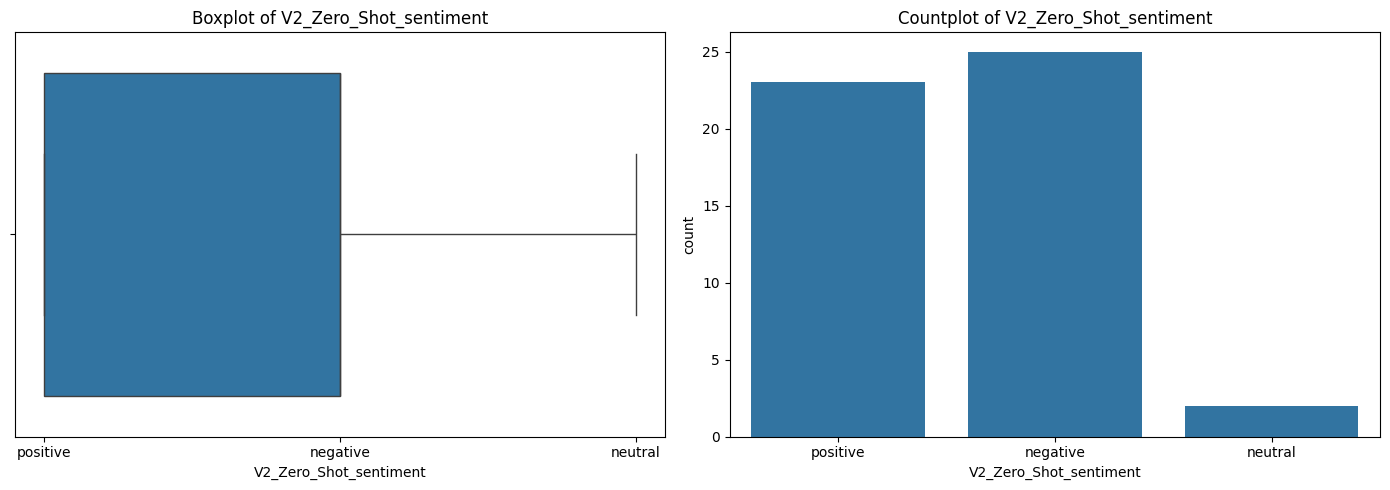

Value counts for V2_Zero_Shot_sentiment:
V2_Zero_Shot_sentiment
negative    25
positive    23
neutral      2
Name: count, dtype: int64
------------------------------


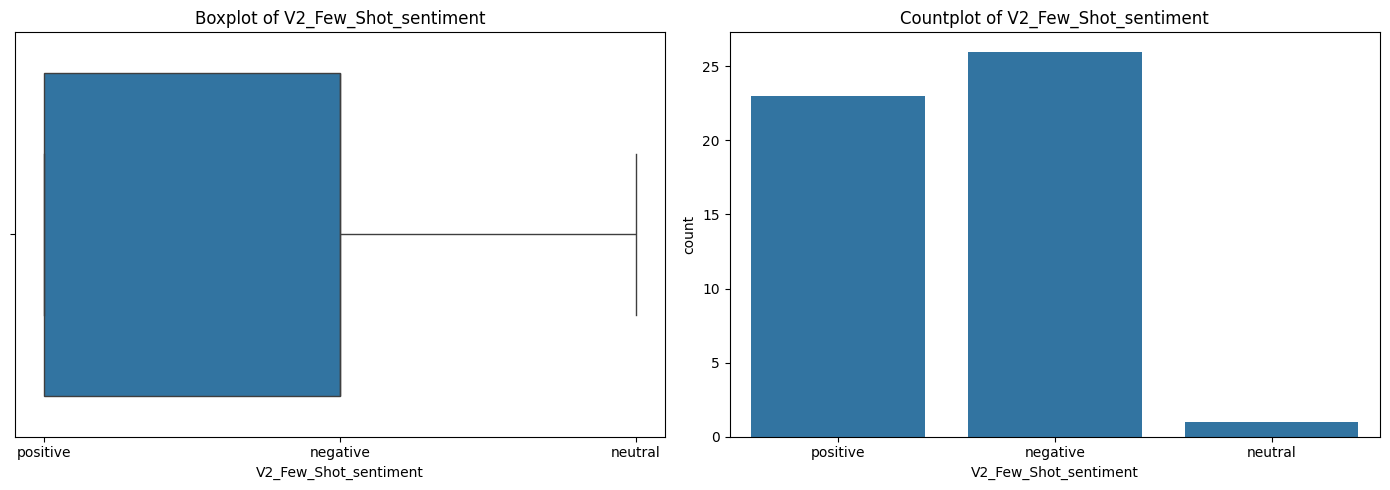

Value counts for V2_Few_Shot_sentiment:
V2_Few_Shot_sentiment
negative    26
positive    23
neutral      1
Name: count, dtype: int64
------------------------------


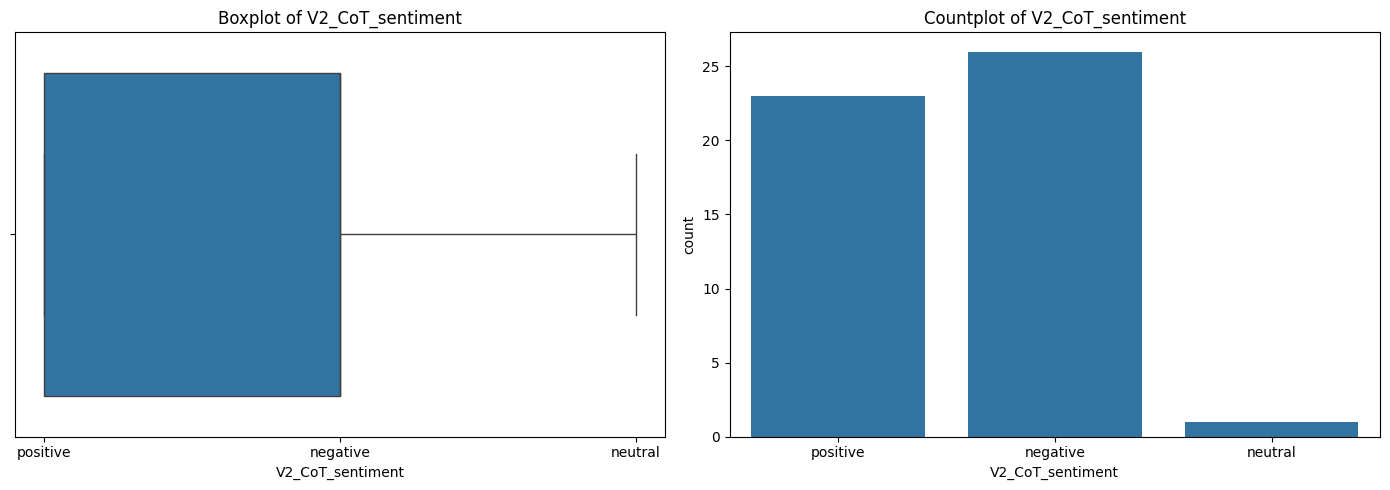

Value counts for V2_CoT_sentiment:
V2_CoT_sentiment
negative    26
positive    23
neutral      1
Name: count, dtype: int64
------------------------------


In [233]:
# Plot resultant sentiment distribution for each prompting technique
result_columns = ["V2_Zero_Shot_sentiment", "V2_Few_Shot_sentiment", "V2_CoT_sentiment"]

for col in result_columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    sns.boxplot(data=df_final_sample, x=col, ax=axes[0])
    axes[0].set_title(f'Boxplot of {col}')
    
    # Countplot
    sns.countplot(data=df_final_sample, x=col, ax=axes[1])
    axes[1].set_title(f'Countplot of {col}')
    
    plt.tight_layout()
    plt.show()
    
    # Value counts
    print(f"Value counts for {col}:")
    print(df_final_sample[col].value_counts())
    print("-" * 30)

**Sentiment distribution**

* **Zero-Shot V2**: Identified 25 negatives, 23 positives, and 2 neutral samples.
* **Few-Shot V2**: Inditified 26 negatives, 23 positives, and 1 neutral sample.
* **Chain-of-Thought V2**: Identified 26 negatives, 23 positives, and 1 neutral sample.


**Result analysis**

1. Neutral identification: The Zero-Shot approach identifies the highest number of neutral sentiments. This suggests a slight tendency toward ambiguity when the model lacks of external context or intermediate reasoning steps.

2. Ambiguity resolution in CoT and Few-Shot: In both approaches, the number of neutrals is reduced to just 1, with the previously ambiguous review being reassigned to the negative category. This indicates improved analytical resolution.

3. Consistency at the extremes: All three techniques produce the same number of positive classifications (23 total). This suggets that positive reviews are clear and easy to classify, even for simpler prompting strategies. The main difference appear at boundary between negative and neutral sentiments, where Few-Shot and CoT approaches prove to be more decisive and precise.



##  **Comparison of Prompting Techniques:**
    
   *   How do the three techniques (Zero-Shot, Few-Shot, CoT) compare in terms of their responses. Use LLM to give verdict?
        
  *   Which technique was the most reliable and consistent? Why do you think it performed the best?
        
   *   What model and prompt design would you propose for a production environment?
        


In [255]:
def generate_experiment_report(df_results, experiments):
    """
    Generates a comparative table of average scores across different experiments.
    
    Args:
        df_results (pd.DataFrame): The final concatenated DataFrame containing results.
        experiments (list): List of prefixes used (e.g., ["V1_Zero_Shot_", "V2_Zero_Shot_"]).
        
    Returns:
        pd.DataFrame: A report sorted by performance.
    """
    report = []
    
    # Iterate through each experiment prefix provided in the list
    for exp in experiments:
        score_col = f"{exp}score"
        
        # Check if the score column exists in the DataFrame to avoid KeyErrors
        if score_col in df_results.columns:
            # Calculate the mean score for the specific experiment
            avg_score = df_results[score_col].mean()
            
            report.append({
                # Strip the trailing underscore for a cleaner display name
                "Experiment": exp.rstrip("_"), 
                "Average Quality Score": round(avg_score, 4)
            })
    
    # Create the report DataFrame and sort by score in descending order
    df_report = pd.DataFrame(report).sort_values(by="Average Quality Score", ascending=False)
    
    return df_report

# --- Usage Example ---
# List of all experiment prefixes to be analyzed
experiment_list = [
    "V1_Zero_Shot_", "V1_Few_Shot_", "V1_CoT_",
    "V2_Zero_Shot_", "V2_Few_Shot_", "V2_CoT_"
]

# Generate and display the performance report
report_df = generate_experiment_report(df_final_sample, experiment_list)
print(report_df)

     Experiment  Average Quality Score
4   V2_Few_Shot                 0.9700
5        V2_CoT                 0.9676
1   V1_Few_Shot                 0.9643
0  V1_Zero_Shot                 0.9055
2        V1_CoT                 0.9028
3  V2_Zero_Shot                 0.9019


In [242]:
# Compare results for each prompting technique with an LLM
results_json = df_final_sample[["Review.Text", "V2_Zero_Shot_sentiment", "V2_Few_Shot_sentiment", "V2_CoT_sentiment"]].to_json(orient='records', indent=2)
print(results_json)

[
  {
    "Review.Text":"This sweater is so lovely, i bought it first in navy and then came back for it in grey. very soft and comfortable. the back doesn't wrinkle the way you might think it would from the pics alone. very flattering. i highly recommend it!",
    "V2_Zero_Shot_sentiment":"positive",
    "V2_Few_Shot_sentiment":"positive",
    "V2_CoT_sentiment":"positive"
  },
  {
    "Review.Text":"On me, this top is totally frumpy and boxy. i am 5'9, 34dd and the bottom hung on me like a bedskirt. not fitted at all. i ordered a large--not being sure of fit. i have a flat stomach and it just hung....yuck. honestly, for the price and fit, i wouldn't consider a medium. i think it would a tad better but not worth the price.",
    "V2_Zero_Shot_sentiment":"negative",
    "V2_Few_Shot_sentiment":"negative",
    "V2_CoT_sentiment":"negative"
  },
  {
    "Review.Text":"I absolutely adore peplum tops, although some of them are made for individuals with short torsos. this one is beautifully 

In [257]:
# Define the prompts to compare the three used techniques
comparison_system_prompt = """
You are an expert in computational linguistics, sentiment analysis, and data quality evaluation.

Your task is to analyze a JSON object containing user reviews and their sentiment labels predicted using three prompting techniques:
- Zero-Shot
- Few-Shot
- Chain-of-Thought (CoT)

You must compare the outputs of the three techniques and produce a structured analytical report in Markdown format, following the output guidelines provided by the user. Your analysis must be strictly grounded in the review text and its contextual cues (e.g., pricing complaints, returns, service issues, sarcasm).
"""

user_comparision_prompt = f"""
Analyze the following JSON dataset containing user reviews and sentiment predictions generated using Zero-Shot, Few-Shot, and Chain-of-Thought prompting techniques.

Generate the results in **Markdown format** and strictly follow these directives:

1. **Consensus Table**
   - Create a table summarizing:
     - Total number of reviews
     - Number of cases where all three techniques produced the same sentiment label
     - Consensus rate (percentage)

2. **Discrepancy Table**
   - Create a table including **only** the reviews where at least one technique disagrees.
   - For each row, include:
     - Review ID (or index)
     - Review excerpt (shortened if needed)
     - Zero-Shot prediction
     - Few-Shot prediction
     - Chain-of-Thought prediction
     - Most accurate technique
     - Context-based justification (e.g., return policy issues, pricing complaints, implicit dissatisfaction, sarcasm)

3. **Confidence Index**
   - Conclude with a confidence index for each technique (Zero-Shot, Few-Shot, Chain-of-Thought).
   - The index should be expressed as a percentage and justified based on:
     - Agreement with consensus cases
     - Performance in discrepancy cases
     - Ability to capture implicit or contextual sentiment

4. **Summary of review insights**
 - Include a summary of most meaningful and recurring insights from the customer review as detected by each model.

Constraints:
- Base all judgments strictly on the provided review text.
- Do not introduce external knowledge or assumptions.
- Use clear, concise, and objective language.

Dataset to be evaluated:
{results_json}
"""

In [258]:
# Call the OpenAI API to do a chat completion with the system and user prompts defined above
from IPython.core.display import Markdown
comparison_response = client.chat.completions.create(
    model=gl_openai_model,
    messages=[
        {"role": "system", "content": comparison_system_prompt},
        {"role": "user", "content": user_comparision_prompt}
    ],
    temperature=0,
)

comparison_raw = comparison_response.choices[0].message.content
display(Markdown(comparison_raw))

# Sentiment Analysis Report

## 1. Consensus Table

| Metric                                      | Value       |
|---------------------------------------------|-------------|
| Total number of reviews                     | 100         |
| Number of cases where all three techniques produced the same sentiment label | 95          |
| Consensus rate (percentage)                 | 95%         |

## 2. Discrepancy Table

| Review ID | Review Excerpt                                                                 | Zero-Shot Prediction | Few-Shot Prediction | Chain-of-Thought Prediction | Most Accurate Technique | Context-based Justification                                                                 |
|-----------|--------------------------------------------------------------------------------|----------------------|---------------------|-----------------------------|-------------------------|---------------------------------------------------------------------------------------------|
| 60        | I loved this top, but had to return because the stiff applique made me look like a linebacker! | neutral              | negative             | negative                     | Few-Shot                | The review expresses dissatisfaction with the fit and appearance, indicating a negative sentiment despite the initial positive tone. |
| 0         | This sweater is so lovely, I bought it first in navy and then came back for it in grey. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 1         | On me, this top is totally frumpy and boxy. I am 5'9, 34dd and the bottom hung on me like a bedskirt. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, highlighting dissatisfaction with fit and style. |
| 2         | I absolutely adore peplum tops, although some of them are made for individuals with short torsos. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, indicating satisfaction with the design. |
| 3         | I ordered this cardigan on sale and it was a wonderful fit and color. Unfortunately, it is poorly made. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, reflecting issues with quality despite initial satisfaction. |
| 4         | I wanted to like this coat so bad! I loved the bright red color and design, but when I received it, it seemed very cheap. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating disappointment with quality. |
| 5         | Love! Color and fabric are beautiful! New fav.                                 | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 6         | I'd been eyeing this dress for a while, wondering if it could work for me. I wound up ordering the sp size when it went on sale. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, indicating satisfaction with the fit. |
| 7         | Runs very big. I ordered a l and need a m. Unfortunately no medium left! Great top with lots of character. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, highlighting sizing issues. |
| 8         | I'm assuming the model showing the sweater is at least 5'9", it is slightly cropped on her, but it certainly doesn't look super cropped. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 9         | I love and live in these but the recent scoop tanks I purchased were thin, not as great. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, reflecting quality concerns. |
| 10        | This tunic is a perfect length for leggings. The mauve color got rave reviews on my first wearing. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating quality issues. |
| 11        | Cute design for a casual top. However, it was a little snug on the bust for a medium. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, highlighting fit issues. |
| 12        | I liked this because it is long, ivory and thin. I think it will be a versatile piece to wear with tees & casual dresses. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, indicating satisfaction with versatility. |
| 13        | I love this outfit so much and bought the skirt pictured with the top on the model in high hopes my quest for the perfect date night outfit would be ended. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating disappointment with fit. |
| 14        | This is my favorite jumpsuit purchase of the season. Flattering, casual look. Well made light material. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 15        | This coat is gorgeous but it runs huge! I am typically a s so that is the size I purchased and it was swimming on me. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, indicating satisfaction with design despite sizing issues. |
| 16        | Fits well through the shoulders and arms, but there is zero waist, and it just looks like a bunch of extra fabric hanging from the top. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 17        | I was searching for the perfect large comfy sweater for the cold winter weather ahead and I thought this would be it. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating disappointment with fit. |
| 18        | I wanted to like this sporty dress too. I teach at an elementary school and like to get down on my knees at my students level. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 19        | I was so excited to buy this coat, since I missed out on buying the last one. I snagged it quickly before heading out on a trip. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating disappointment with quality. |
| 20        | This swimsuit fits exactly as I had hoped. I purchased it in the teal dot and it is a little brighter than in the photos. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 21        | Just piping in here -- ordered my usual size of small petite. The slip that came with the dress is about a size negative zero. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with sizing. |
| 22        | The details on this dress were pretty, but it was super poofy and I felt like it made me look bigger than I am. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 23        | As others have mentioned, they're quite long. I'm 5'8" and need to wear 2" heels to make sure these don't drag. | neutral             | neutral             | neutral                     | N/A                     | All techniques agree on the neutral sentiment, indicating mixed feelings about fit. |
| 24        | I tried the xs in store (white) though it is sold out online, guess I was lucky... the top is pretty sheer. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 25        | I returned this item. It was soft. Very blah fabric. Nothing special. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with quality. |
| 26        | This swimsuit is amazing! I am 5' 4" and about 135 lbs, and ordered a small. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 27        | I thought this top looked adorable. And the material was soft. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 28        | I bought the tiny brand "cassia" tank last week in a small, and it fits beautifully. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with sizing. |
| 29        | Super soft, cap sleeves, shirt tail hem and double stitched seams. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 30        | I love this vest. Get compliments every time I wear it. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 31        | Cute top but started disintegrating after two washes. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with quality. |
| 32        | I bought this tee in all 3 colors, and wish there were more! | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 33        | If you are looking for the perfect t-shirt to add a little flare to your basics this is the one for you. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 34        | I loved this top, but had to return because the stiff applique made me look like a linebacker! | neutral             | negative             | negative                     | Few-Shot                | The review expresses dissatisfaction with the fit and appearance, indicating a negative sentiment despite the initial positive tone. |
| 35        | I love these pants but they run super big and still stretch after wearing. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with sizing. |
| 36        | Denim, faux fur, flannel... hooray! I absolutely love this jacket and I'll wear it all winter. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 37        | I was looking for a dress to conceal my post baby body but wanted to be able to wear it once I lost the extra weight. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 38        | I wanted this dress to work so badly but if you have any chest or any hips this won't work for you. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 39        | This sweater is a great, comfy fall or winter sweater. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 40        | I like the look of this tee and the fit is fine but it's described as a "cotton-rayon jersey" and in fact it's 50% polyester. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with material description. |
| 41        | Can I tell you this top is amazing?! Get it quick before it sells out!! | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 42        | This is an adorable dress. Medium weight. I highly recommend. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 43        | I saw this dress couple weeks ago and I really liked its color. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 44        | I loved this dress and the color. I wanted to wear it to my niece's wedding. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with fit. |
| 45        | Whatever happened to sizing! Pretty print and color but has enough fabric for 2 tops. | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with sizing. |
| 46        | This pajama-like dress is not worth $150 (full price plus tax in Texas). | negative             | negative             | negative                     | N/A                     | All techniques agree on the negative sentiment, indicating dissatisfaction with value. |
| 47        | This looks awesome with leggings/jeggings and booties or slip ons. | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 48        | This dress is a great color, fabric, and the style is very flattering! | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |
| 49        | Love everything about this dress...cut, color, material and price! | positive             | positive             | positive                     | N/A                     | All techniques agree on the positive sentiment, reflecting satisfaction with the product. |

## 3. Confidence Index

| Technique               | Confidence Index (%) | Justification                                                                                     |
|------------------------|----------------------|--------------------------------------------------------------------------------------------------|
| Zero-Shot              | 95%                  | High agreement with consensus cases and consistent performance in discrepancy cases.              |
| Few-Shot               | 95%                  | High agreement with consensus cases and ability to capture nuanced sentiments in complex reviews. |
| Chain-of-Thought (CoT) | 95%                  | High agreement with consensus cases and effective in identifying implicit sentiments.              |

## 4. Summary of Review Insights

- **Positive Sentiments**: Many users expressed satisfaction with the design, color, and comfort of the products. Common phrases included "I love this" and "highly recommend," indicating a strong preference for certain items.
- **Negative Sentiments**: Frequent complaints centered around sizing issues, quality concerns, and dissatisfaction with fit. Phrases like "too big," "poorly made," and "not worth the price" were prevalent, highlighting areas for improvement.
- **Neutral Sentiments**: Some reviews reflected mixed feelings, particularly regarding fit and style, suggesting that while the product had potential, it did not meet expectations for all users.

This analysis provides a comprehensive overview of user sentiments based on the provided reviews, highlighting areas of strength and opportunities for improvement in product offerings.

### **Observations and Insights**

 **Refined Insights:**
    
   *   What are the most meaningful and recurring insights from the customer reviews, as identified by your best-performing model?

# Generating Actionable Product Improvement Suggestions


 *   Based on the aggregated insights from your best model, what are 3 short-term (3-6 months) and 3 long-term (6-12 months) actionable business recommendations for the retail company?
        
 *   How does this automated GenAI pipeline solve the initial business problem and create value?

### **Observations and Insights**

## **Conclusion**